# Explore Fuse Pose Estimates
Stefan/Yuzhao Heng
Since Tues. Nov. 2nd, 2021

i.e. Get pose candidates from the HSR's laser scan in locating KUKA, and candidates from KUKA's laser scan in locating HSR.


## Setup



In [1]:
from icecream import ic

from scripts.util import *
from scripts.robo_pose_estimator import *


rcParams["figure.dpi"] = 300
rcParams['font.size'] = 6

pts_hsr = eg_hsr_scan()
guesses = config('heuristics.pose_guess')



## A straightforward approach: ICP

### Setup
Empirically have `robot_a` as HSR, `robot_b` as KUKA



In [2]:
pcr_kuka = get_kuka_pointcloud()
fp = PoseEstimator.FusePose(pcr_b=pcr_kuka)



### No guess whatsoever
i.e. Identity transformation


#### Source as laser scans
Not good, too much noise



ic| 'Initial guess': 'Initial guess'
    init_tsf: array([[1., 0., 0.],
                     [0., 1., 0.],
                     [0., 0., 1.]])
ic| tsf_: array([[ 0.99722373, -0.07446362,  0.25425722],
                 [ 0.07446362,  0.99722373,  0.39325788],
                 [ 0.        ,  0.        ,  1.        ]])
    tsl: array([0.25425722, 0.39325788])
    degrees(theta): 4.270403888855923


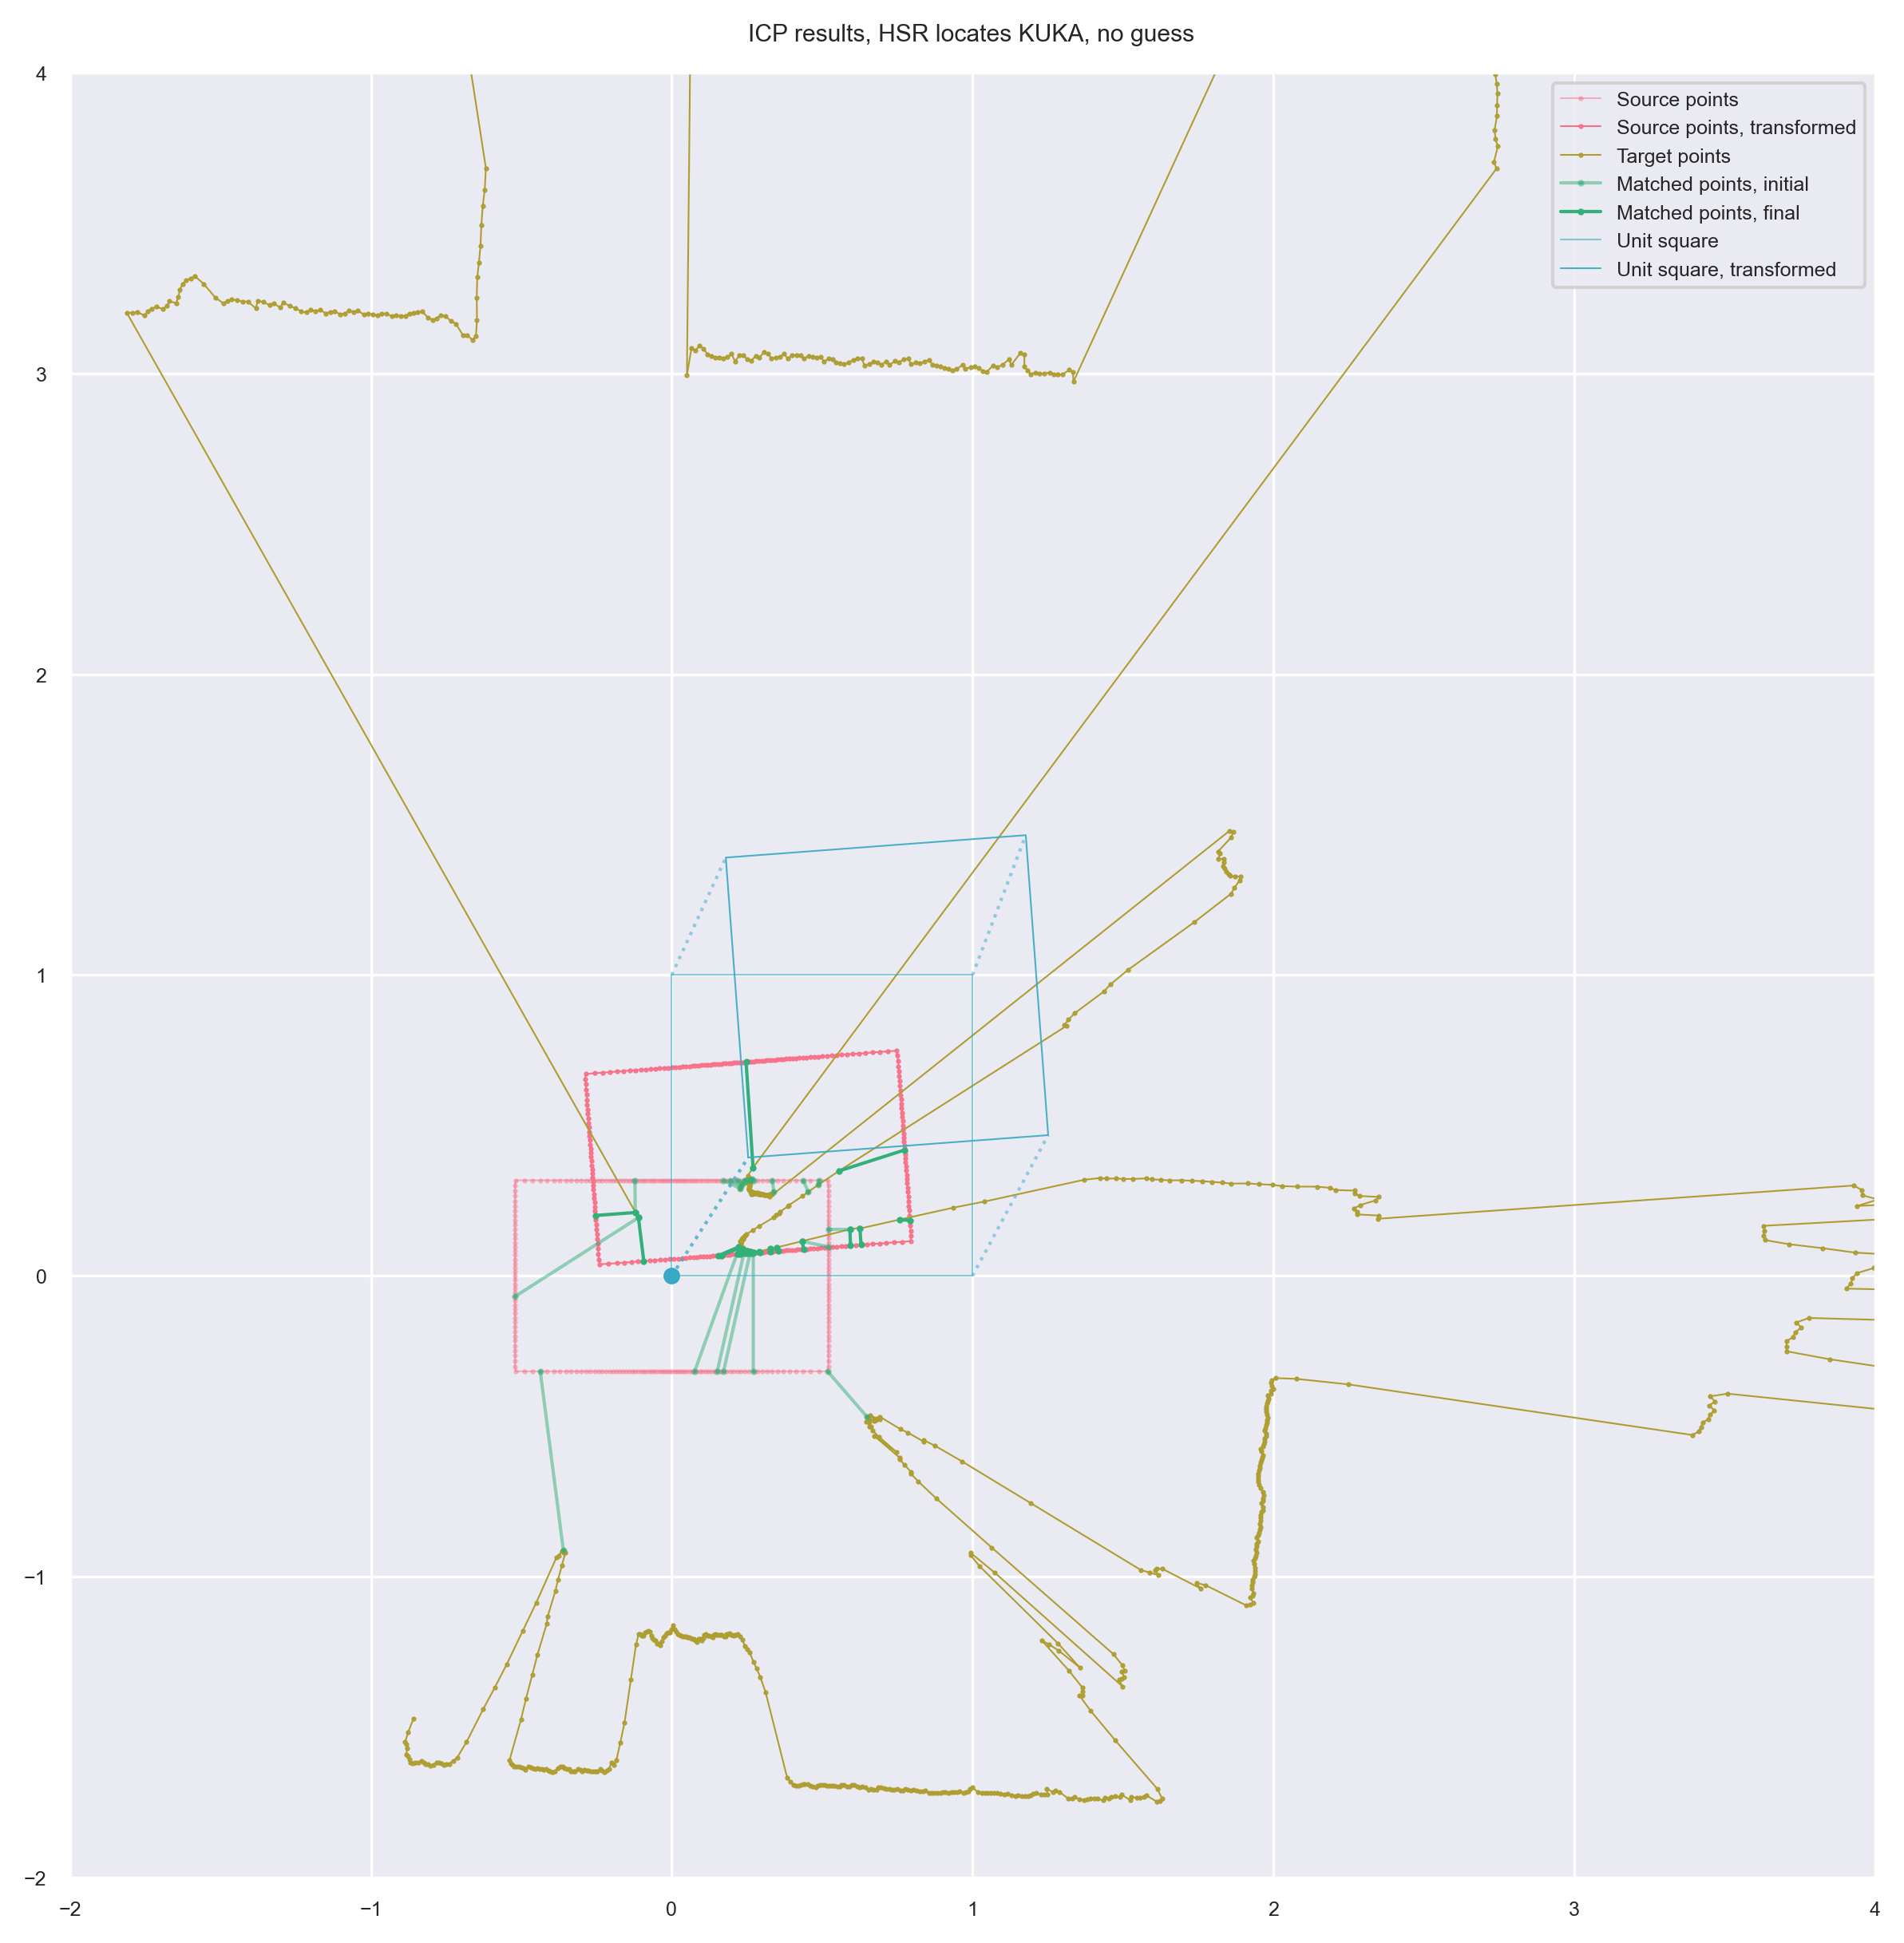

In [3]:
visualize(
    pcr_kuka, pts_hsr,
    title='HSR locates KUKA, no guess',
    xlim=[-2, 4], ylim=[-2, 4],
    save=True,
    with_arrow=False
)



#### The reversed direction
Since we match each point in source to any points in target, this direction is not good



ic| 'Initial guess': 'Initial guess'
    init_tsf: array([[1., 0., 0.],
                     [0., 1., 0.],
                     [0., 0., 1.]])
ic| tsf_: array([[ 0.80362475,  0.59513634, -2.5037136 ],
                 [-0.59513634,  0.80362475, -0.53233406],
                 [ 0.        ,  0.        ,  1.        ]])
    tsl: array([-2.5037136 , -0.53233406])
    degrees(theta): 36.522352308269596


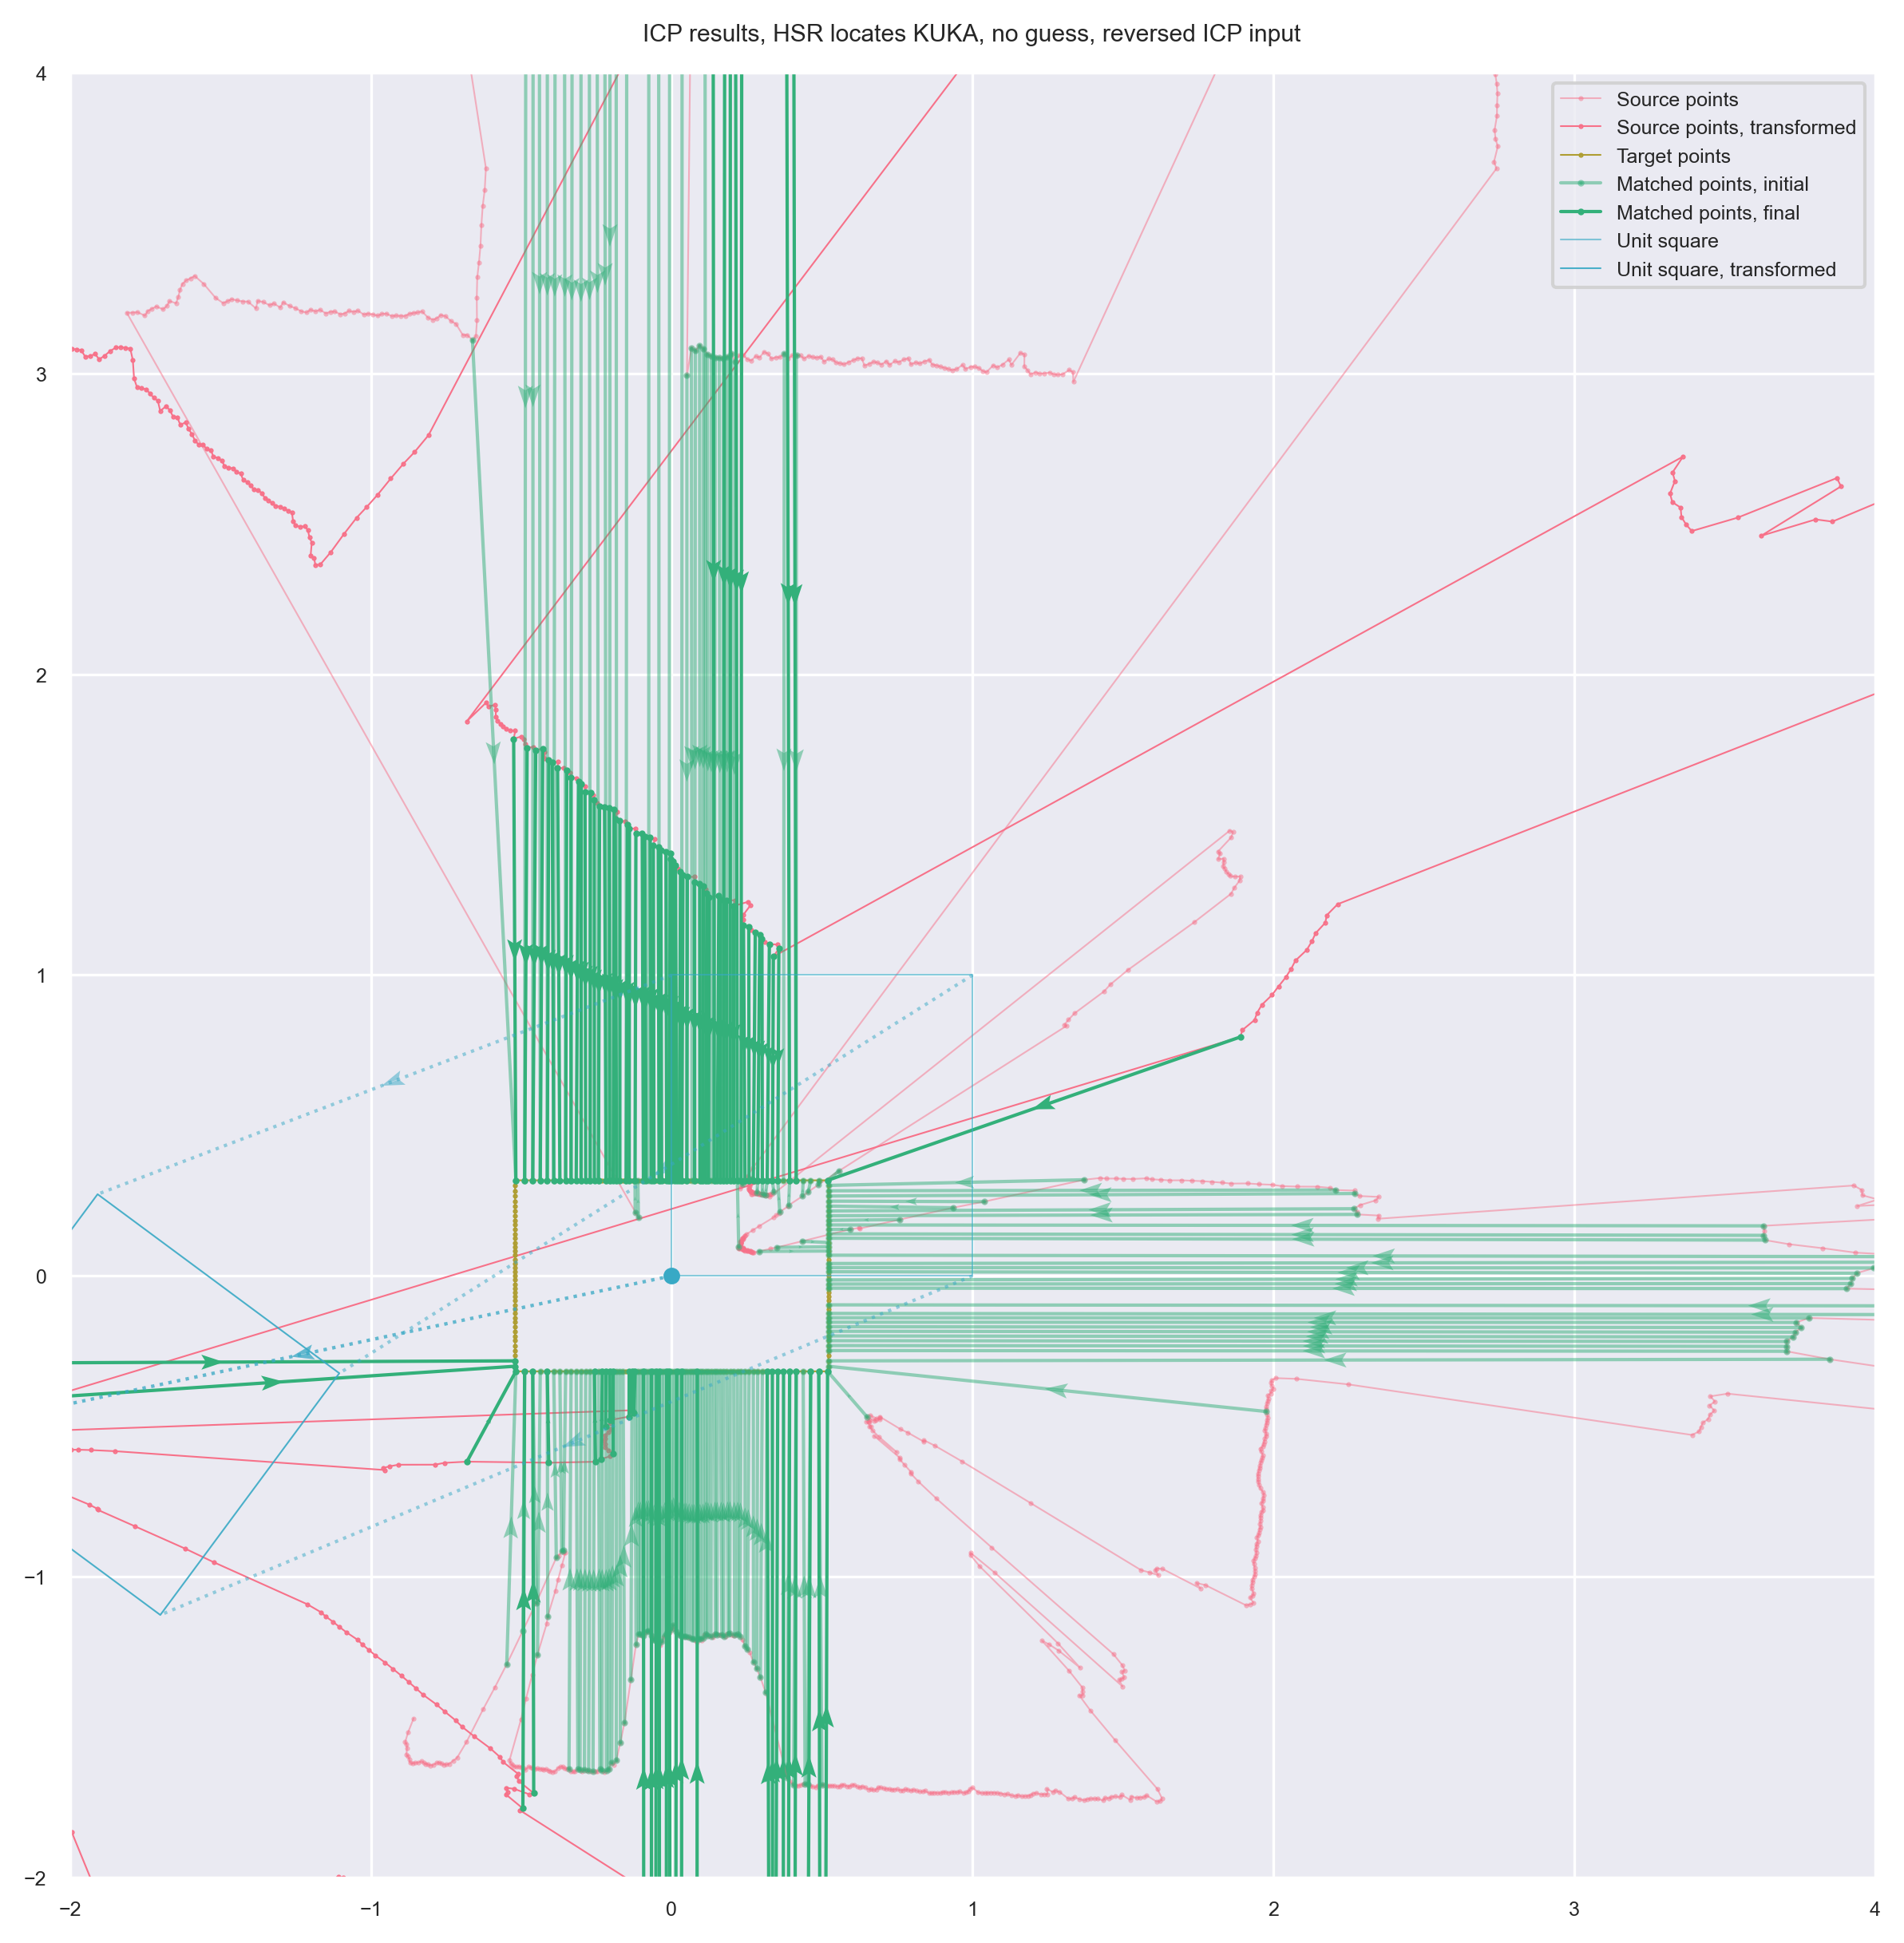

In [4]:
visualize(
    pts_hsr, pcr_kuka,
    title='HSR locates KUKA, no guess, reversed ICP input',
    xlim=[-2, 4], ylim=[-2, 4],
    save=True
)



### An almost perfect guess
We guide the ICP with a good guess, where only rotation is wrong
But the raw ICP output is not ideal



ic| 'Initial guess': 'Initial guess'
    init_tsf: array([[ 1. , -0. ,  2.5],
                     [ 0. ,  1. , -0.5],
                     [ 0. ,  0. ,  1. ]])
ic| tsf_: array([[ 0.97860324,  0.20575641,  2.98679523],
                 [-0.20575641,  0.97860324, -0.09447856],
                 [ 0.        ,  0.        ,  1.        ]])
    tsl: array([ 2.98679523, -0.09447856])
    degrees(theta): 11.873782101241995


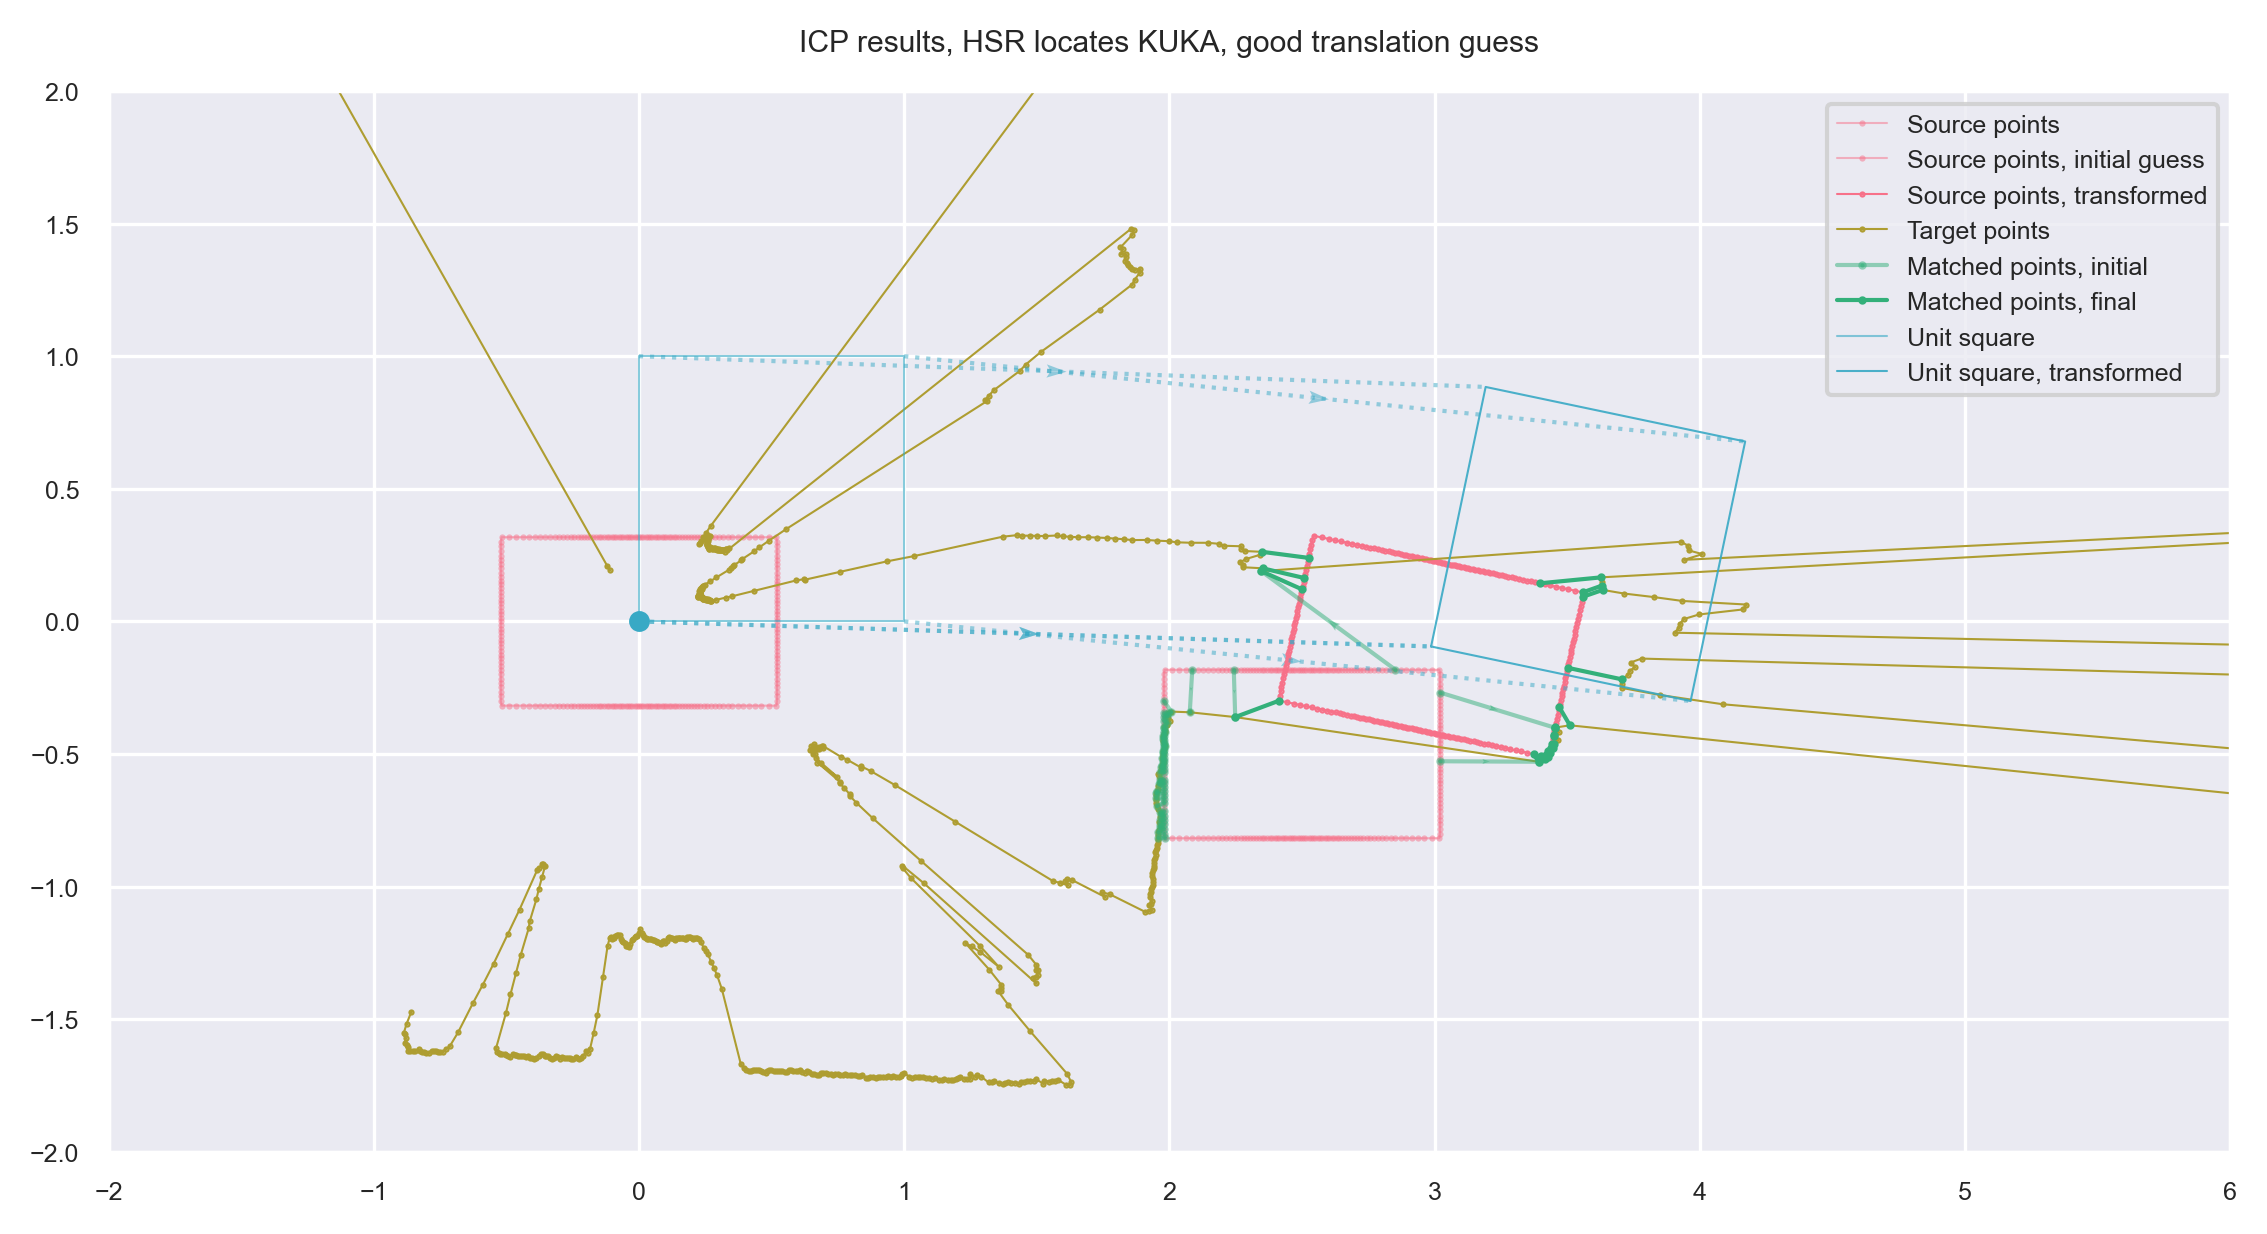

In [5]:
visualize(
    fp.pcr_b, pts_hsr,
    init_tsf=tsl_n_angle2tsf(guesses['good_no_rotation']),
    title='HSR locates KUKA, good translation guess',
    xlim=[-2, 6], ylim=[-2, 2]
)



## A perfect guess?
The noise in the HSR laser scans breaks up the initial good estimates



ic| 'Initial guess': 'Initial guess'
    init_tsf: array([[ 0.98877108,  0.14943813,  2.5       ],
                     [-0.14943813,  0.98877108, -0.75      ],
                     [ 0.        ,  0.        ,  1.        ]])
ic| tsf_: array([[ 0.9215292 ,  0.38830908,  2.77794104],
                 [-0.38830908,  0.9215292 , -0.37008568],
                 [ 0.        ,  0.        ,  1.        ]])
    tsl: array([ 2.77794104, -0.37008568])
    degrees(theta): 22.849326090185947


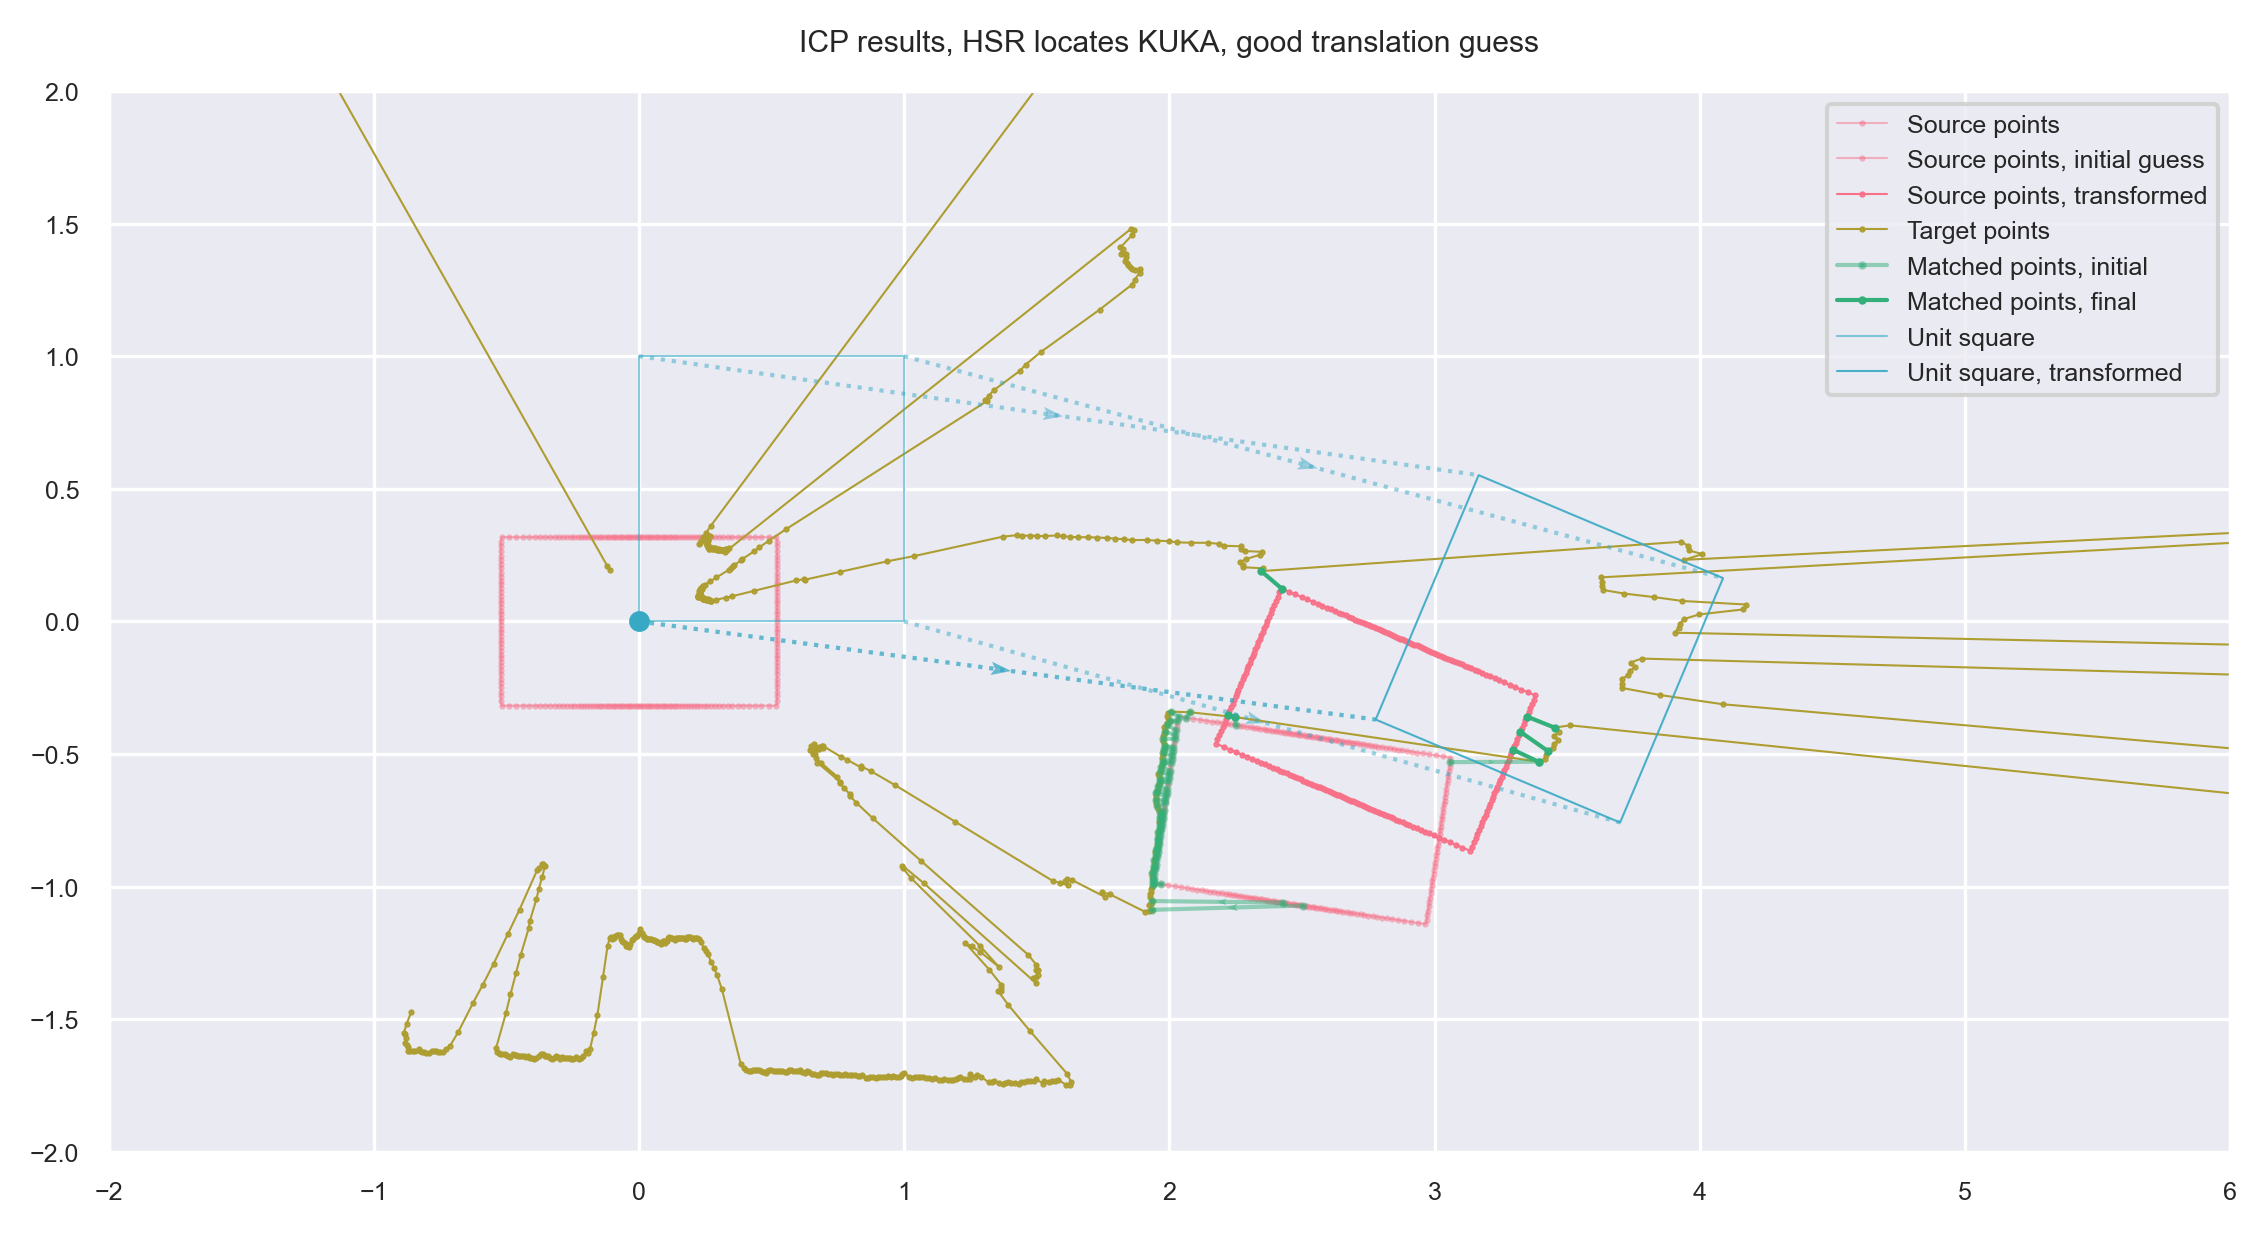

In [6]:
visualize(
    fp.pcr_b, pts_hsr,
    init_tsf=tsl_n_angle2tsf(guesses['actual_pose']),
    title='HSR locates KUKA, good translation guess',
    xlim=[-2, 6], ylim=[-2, 2]
)



## Cluster the point clouds first
then run ICP on each, with the relative translation to cluster center


### Clustering
What algorithm work well? Ideally the number of clusters shouldn't be fixed.


#### Setup



In [7]:
c = Cluster.cluster



#### Spectral Clustering



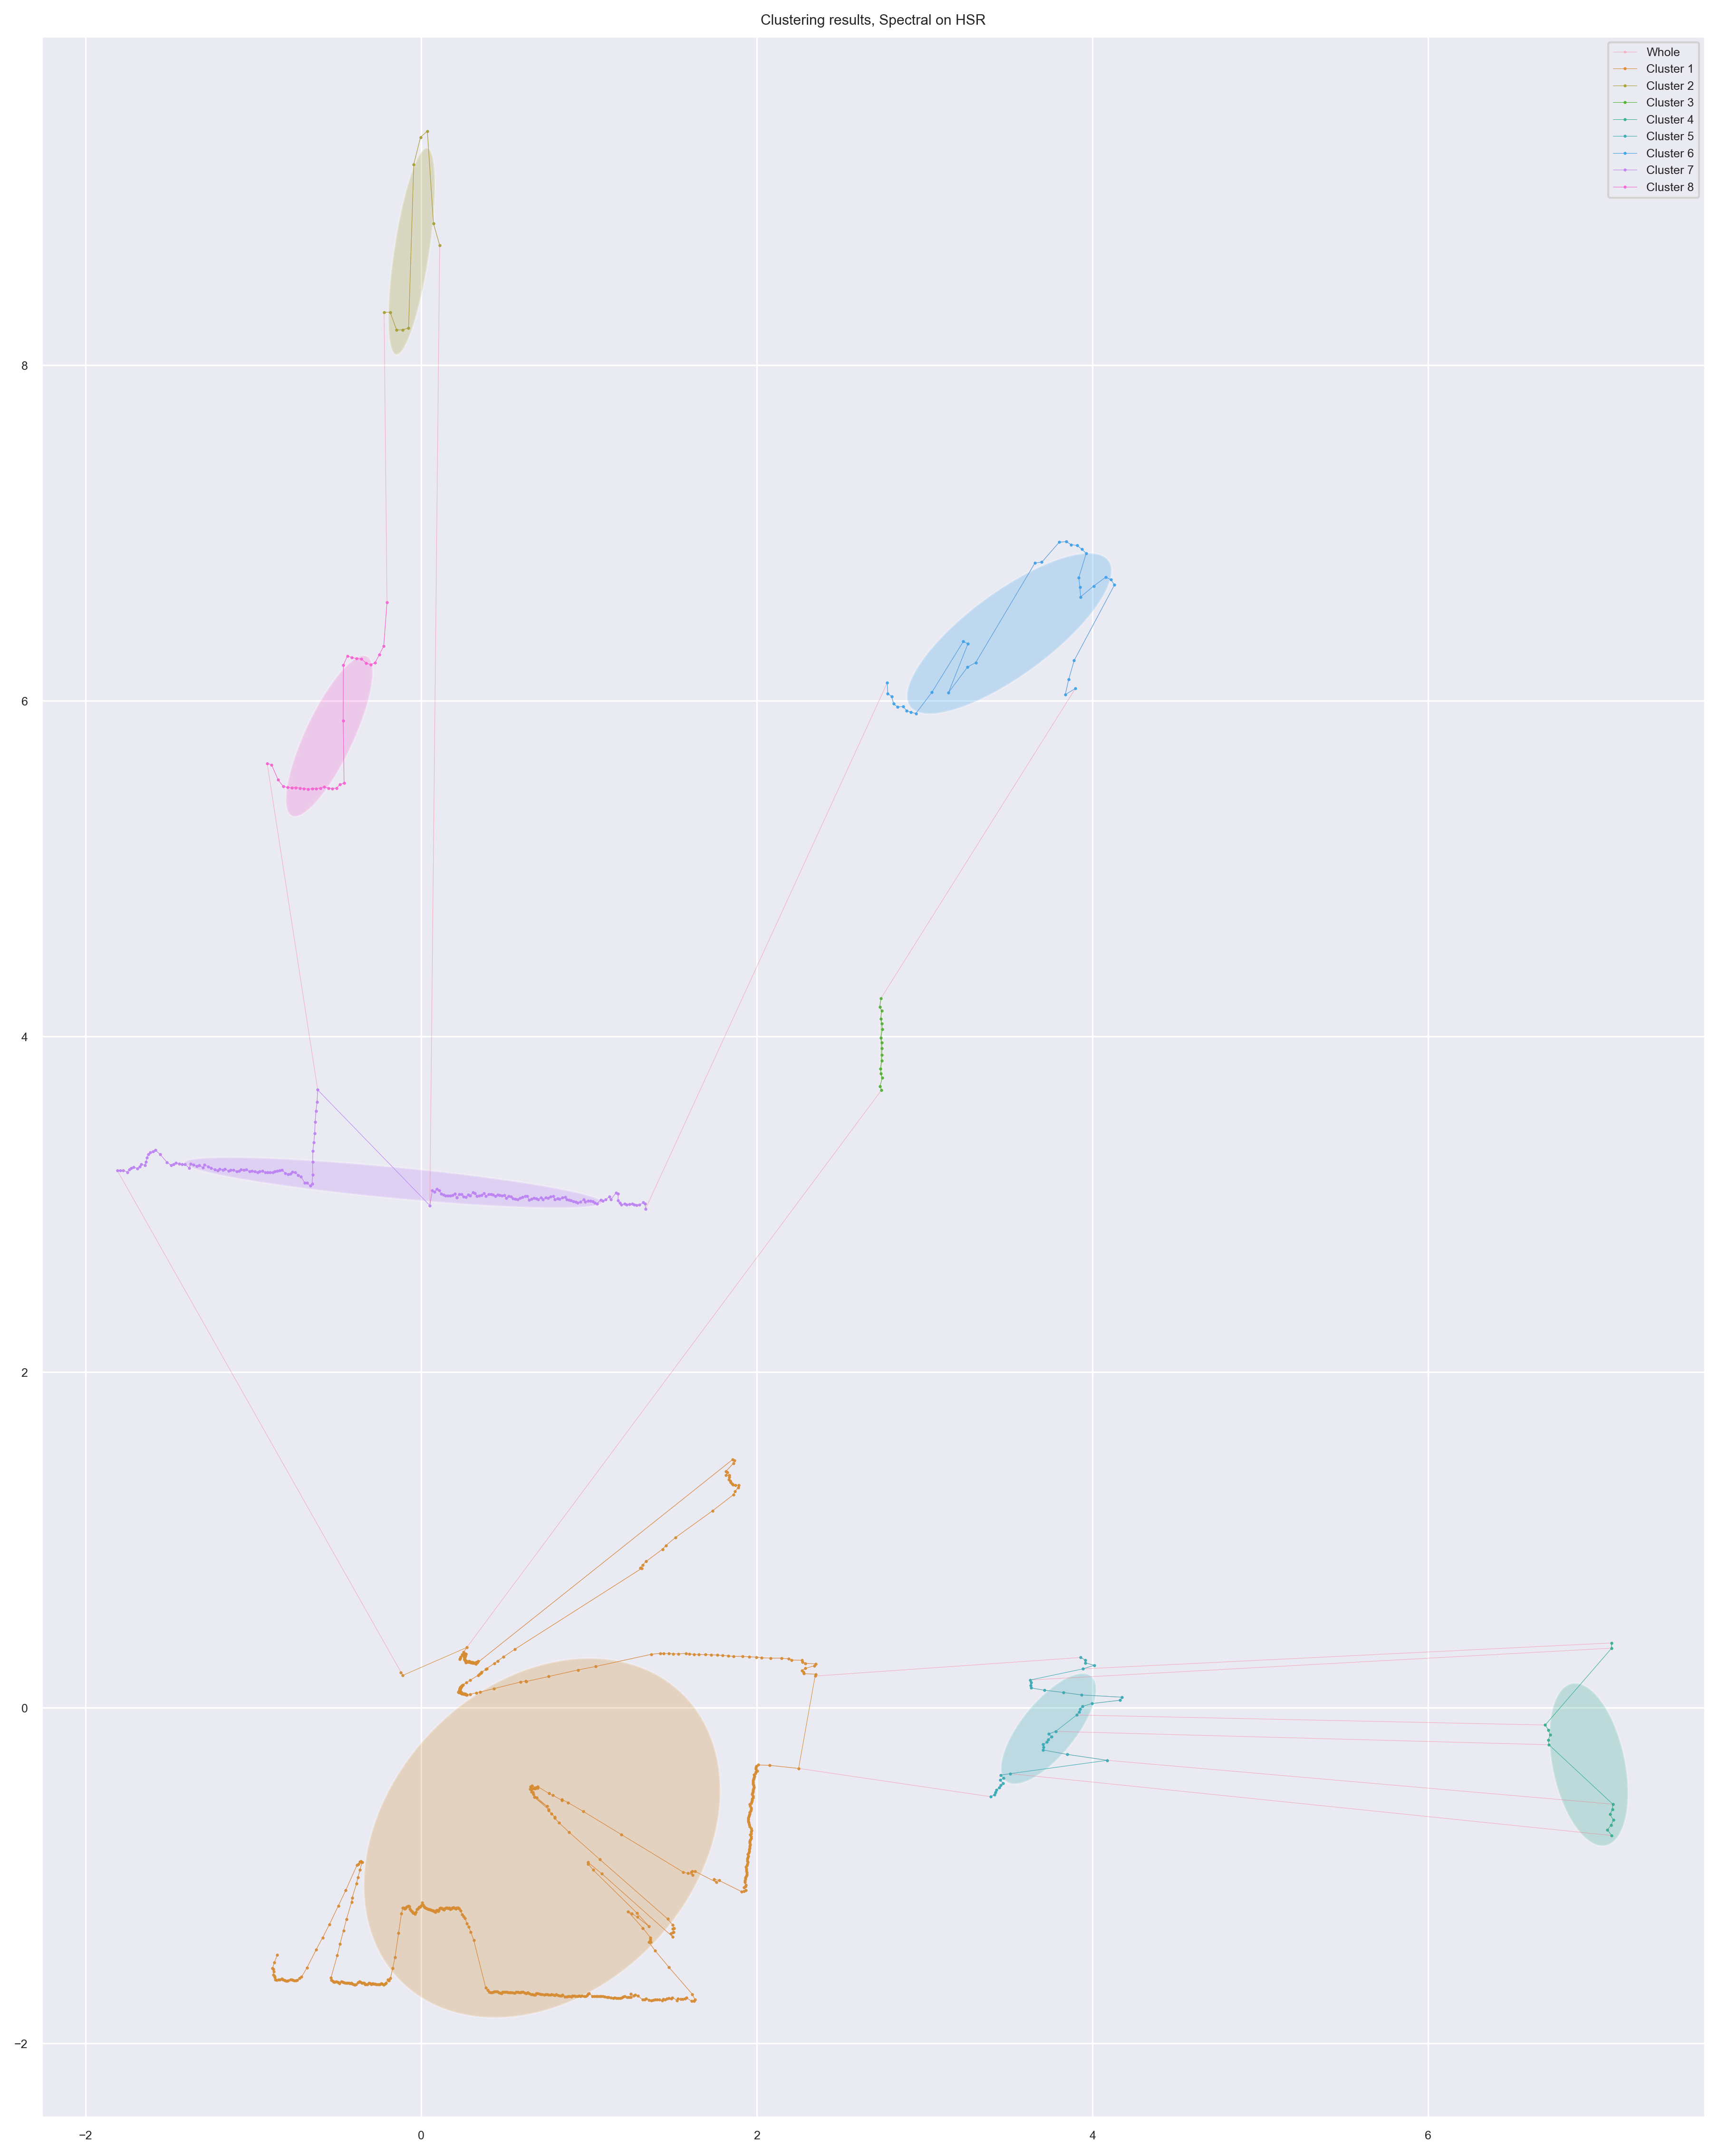

In [8]:
lbs = c(pts_hsr, approach='spectral', n_clusters=8)
plot_cluster(pts_hsr, lbs, title='Spectral on HSR')



#### Hierarchical Clustering



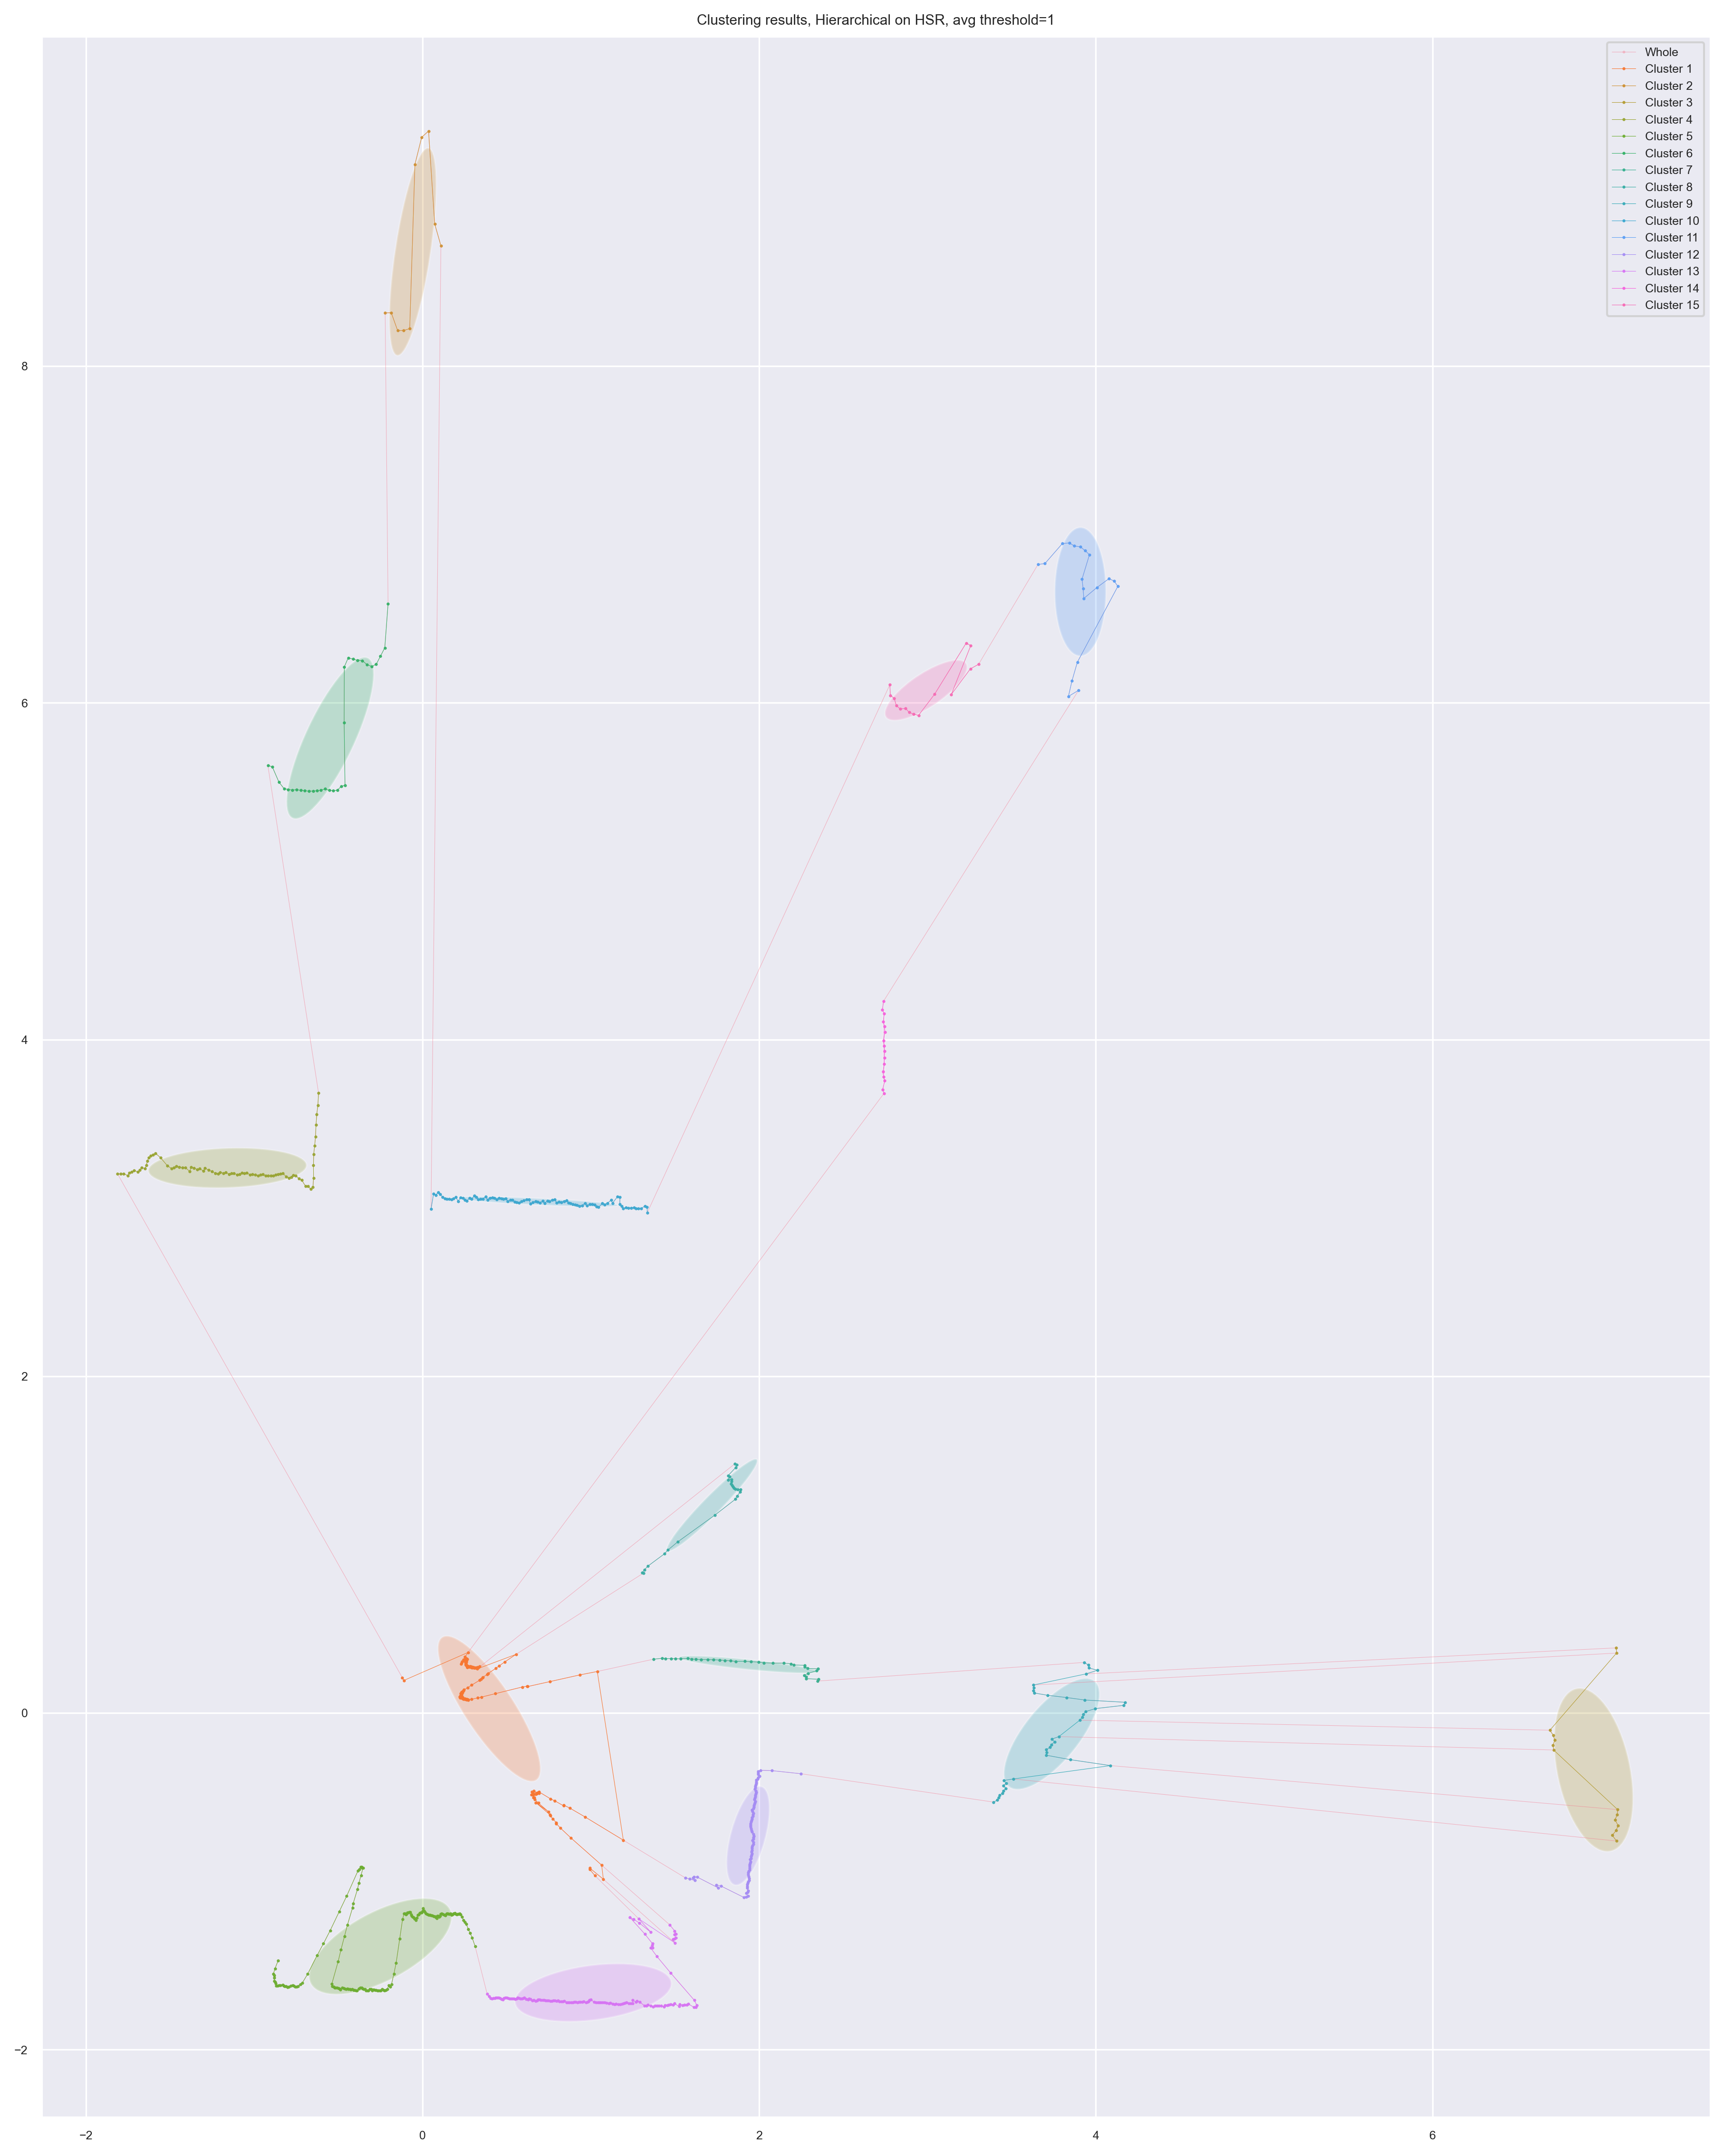

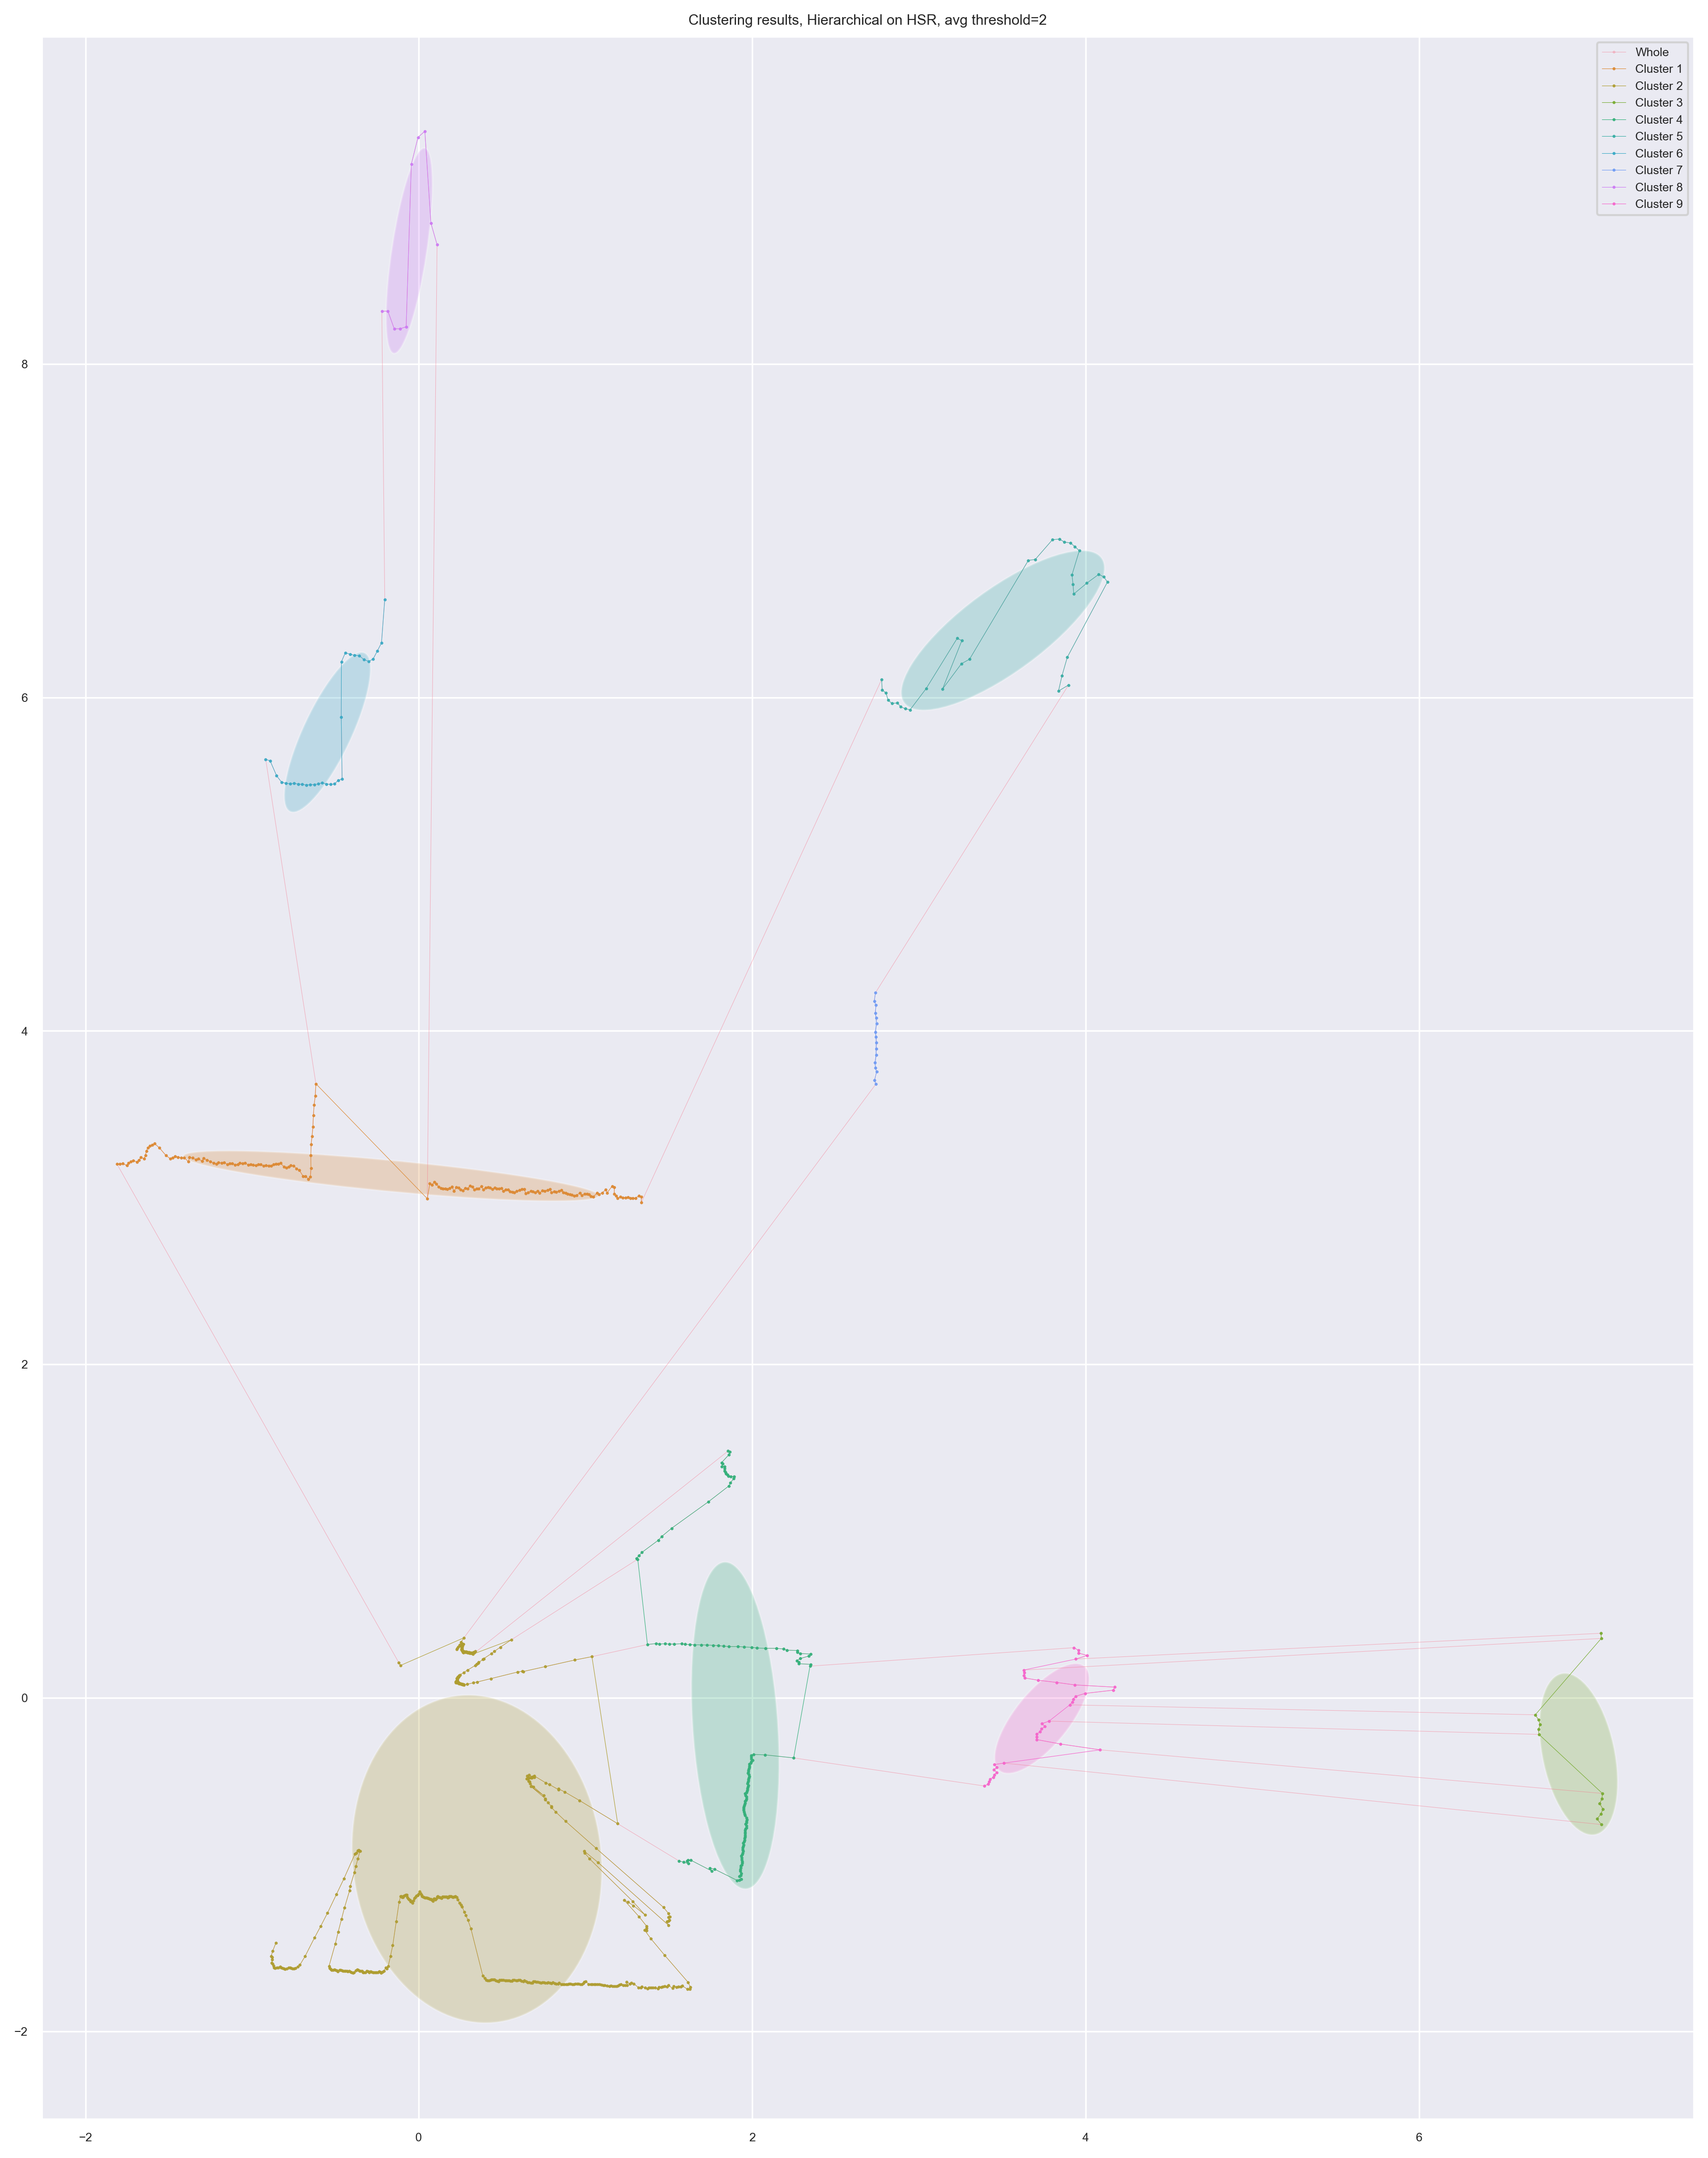

In [9]:
def _(d):
    lbs = c(pts_hsr, approach='hierarchical', distance_threshold=d)
    plot_cluster(pts_hsr, lbs, title=f'Hierarchical on HSR, avg threshold={d}')

_(1)
_(2)



#### Gaussian Mixture Model assignment



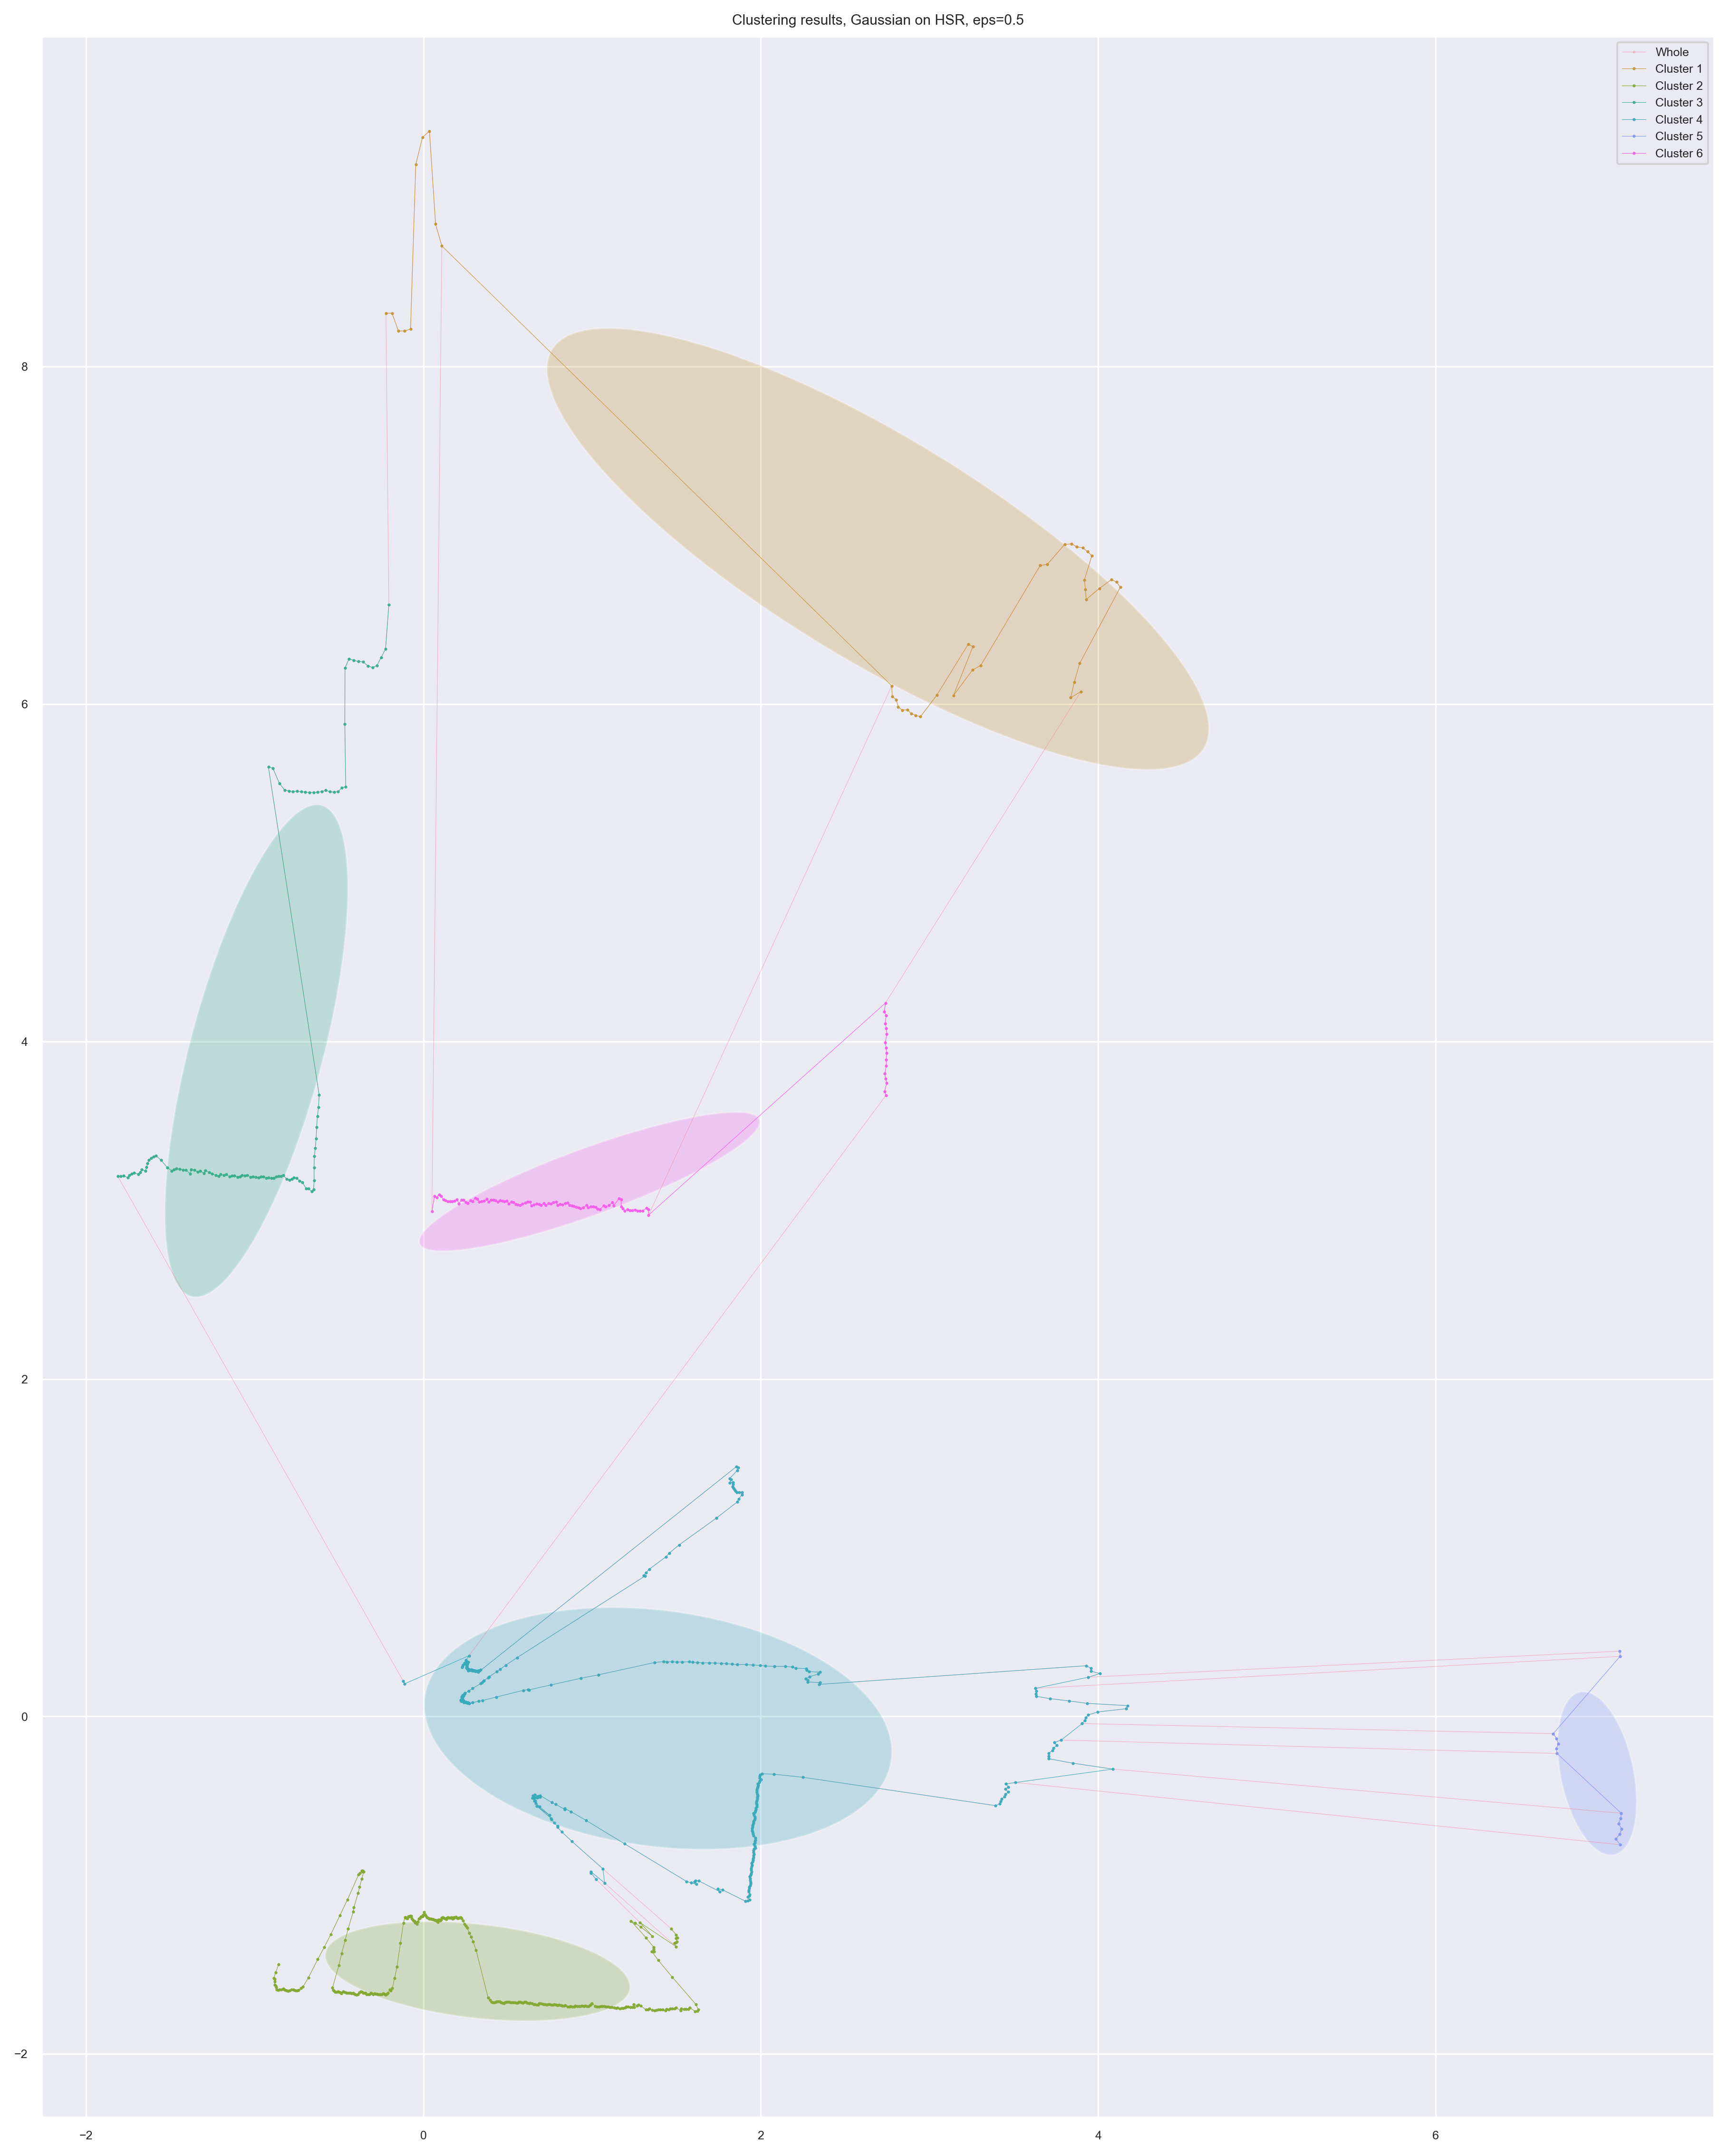

In [10]:
lbs = c(pts_hsr, approach='gaussian', n_components=6)
plot_cluster(pts_hsr, lbs, title='Gaussian on HSR, eps=0.5')



#### DBSCAN



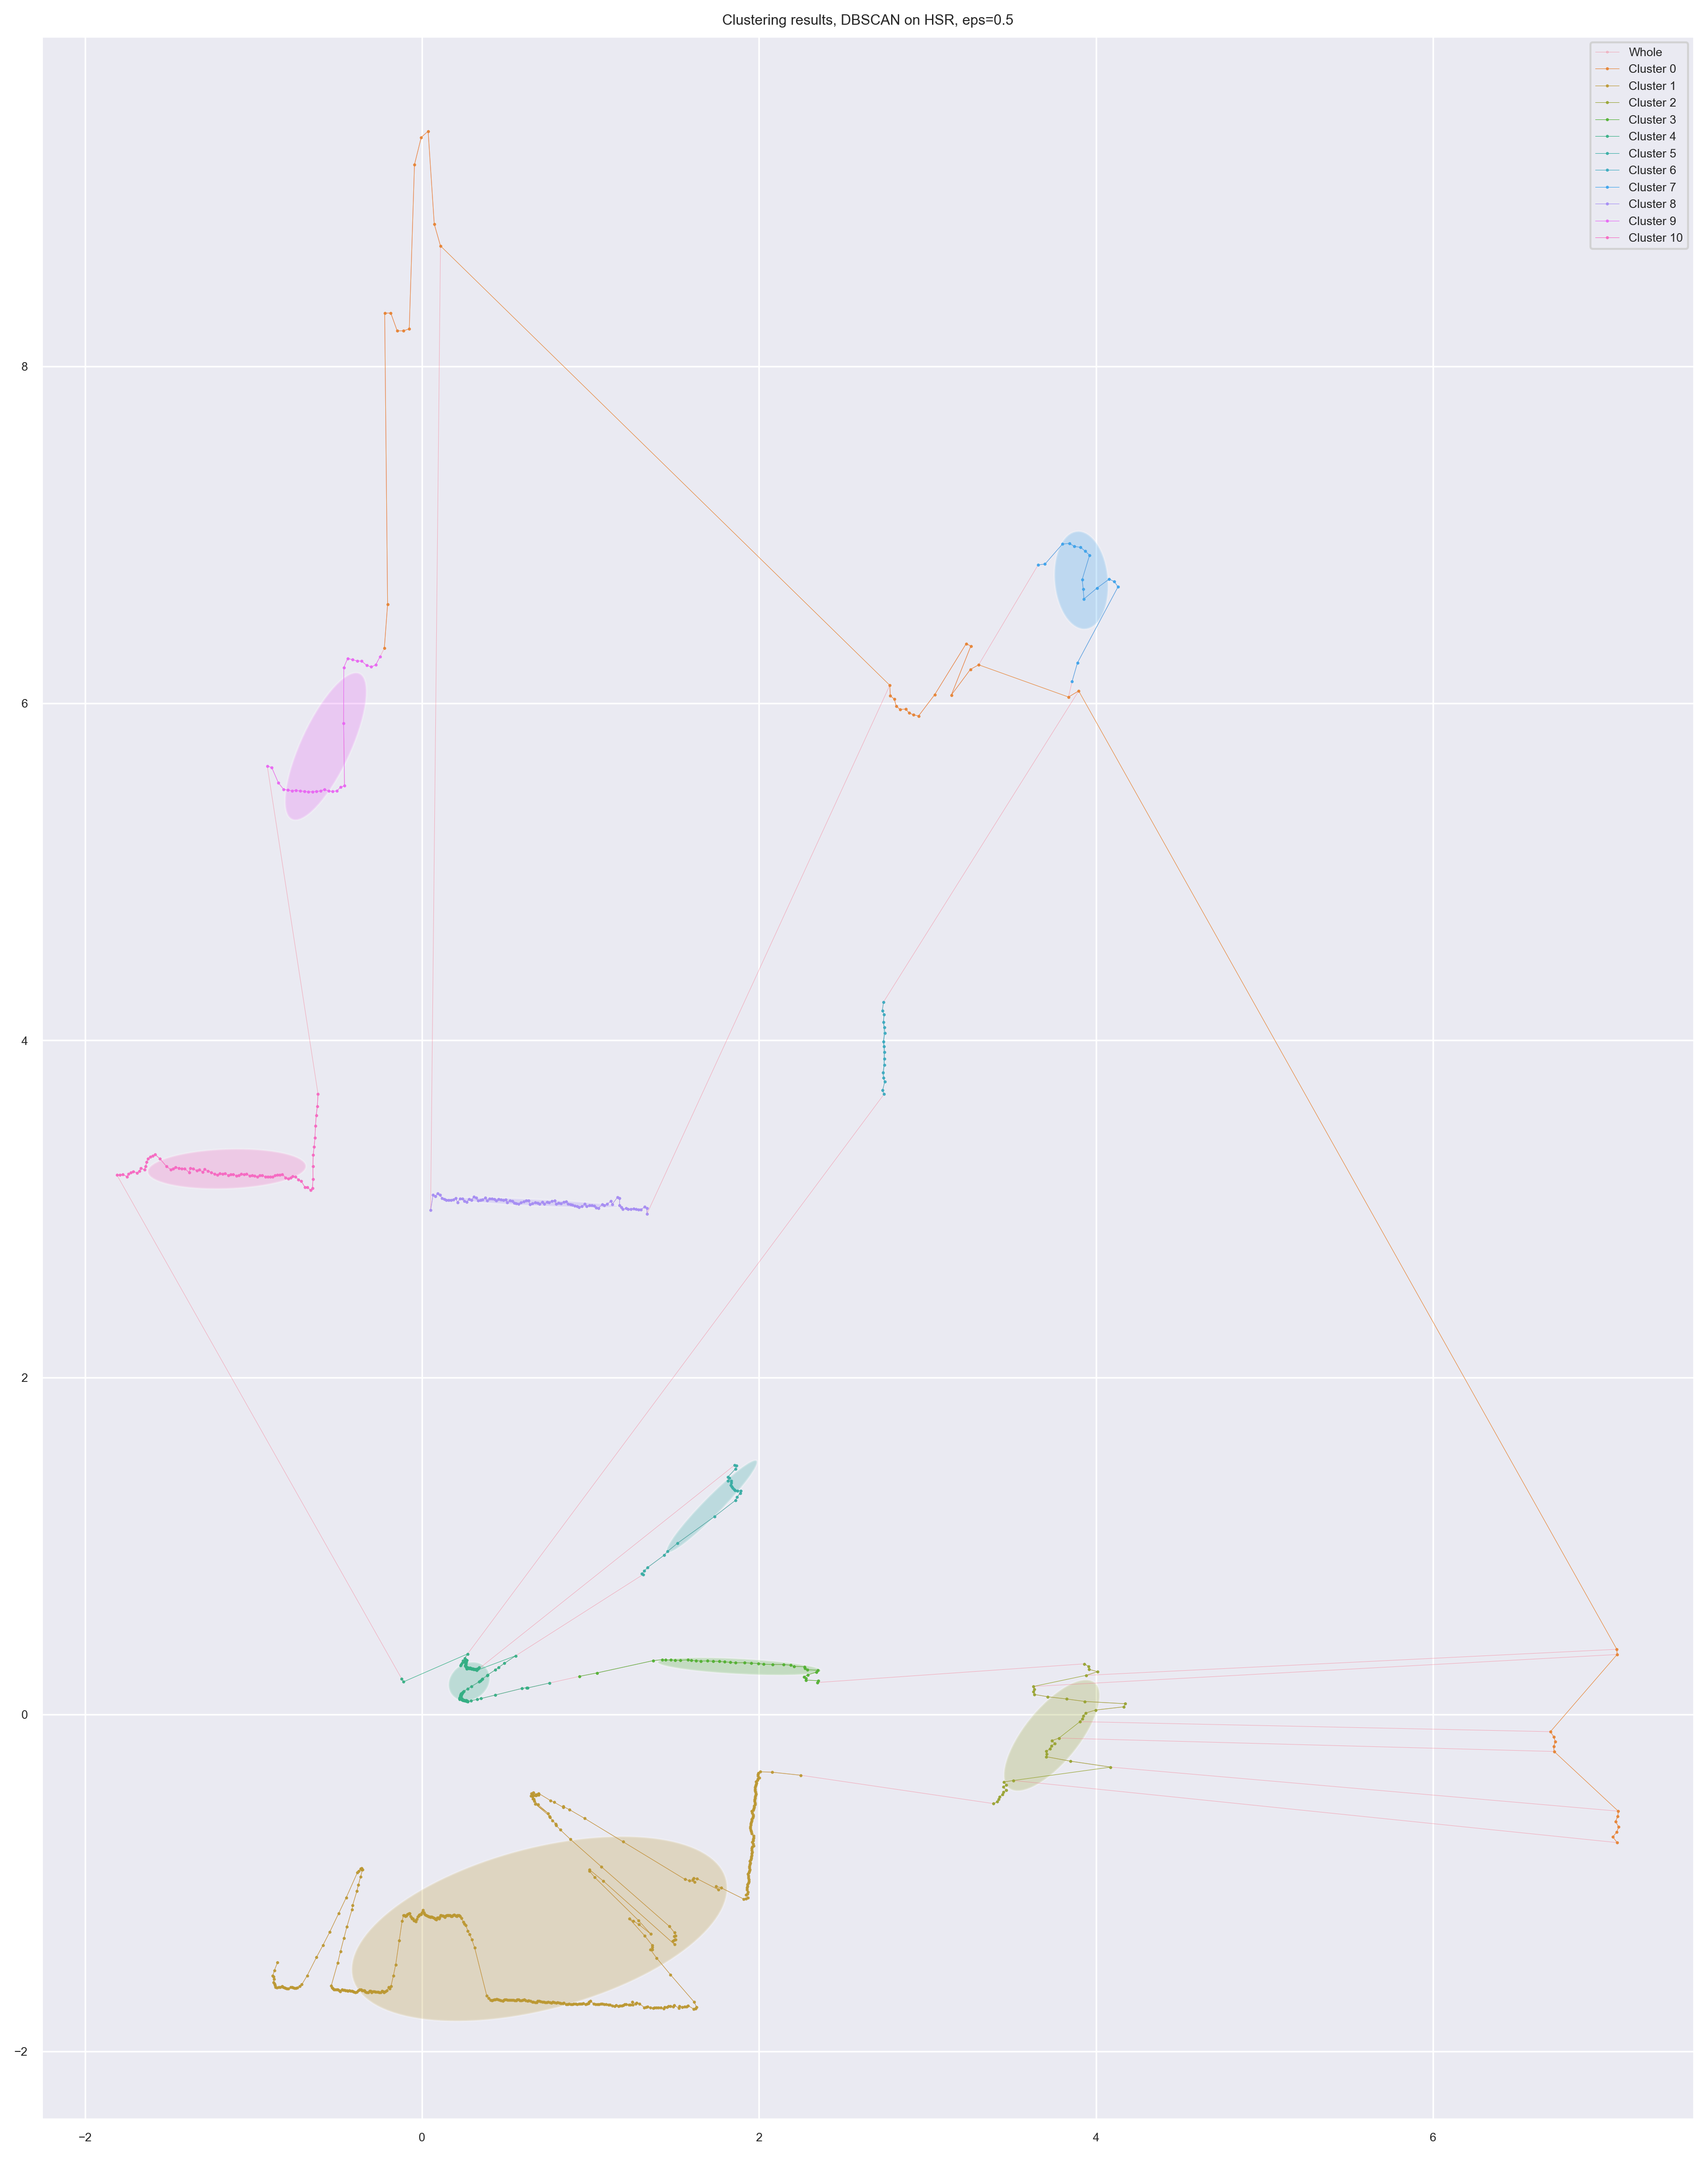

In [11]:
lbs = c(pts_hsr, approach='dbscan', eps=0.5, min_samples=16)
plot_cluster(pts_hsr, lbs, title='DBSCAN on HSR, eps=0.5')


### ICP with cluster translation initialisation


ic| 'Initial guess': 'Initial guess'
    init_tsf: array([[ 1.        , -0.        ,  1.93388482],
                     [ 0.        ,  1.        , -0.72910732],
                     [ 0.        ,  0.        ,  1.        ]])
ic| tsf_: array([[-8.85730201e-01, -4.64200400e-01,  7.24175053e+25],
                 [ 4.64200400e-01, -8.85730201e-01,  9.62096357e+25],
                 [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
    tsl: array([7.24175053e+25, 9.62096357e+25])
    degrees(theta): 152.3415144386748


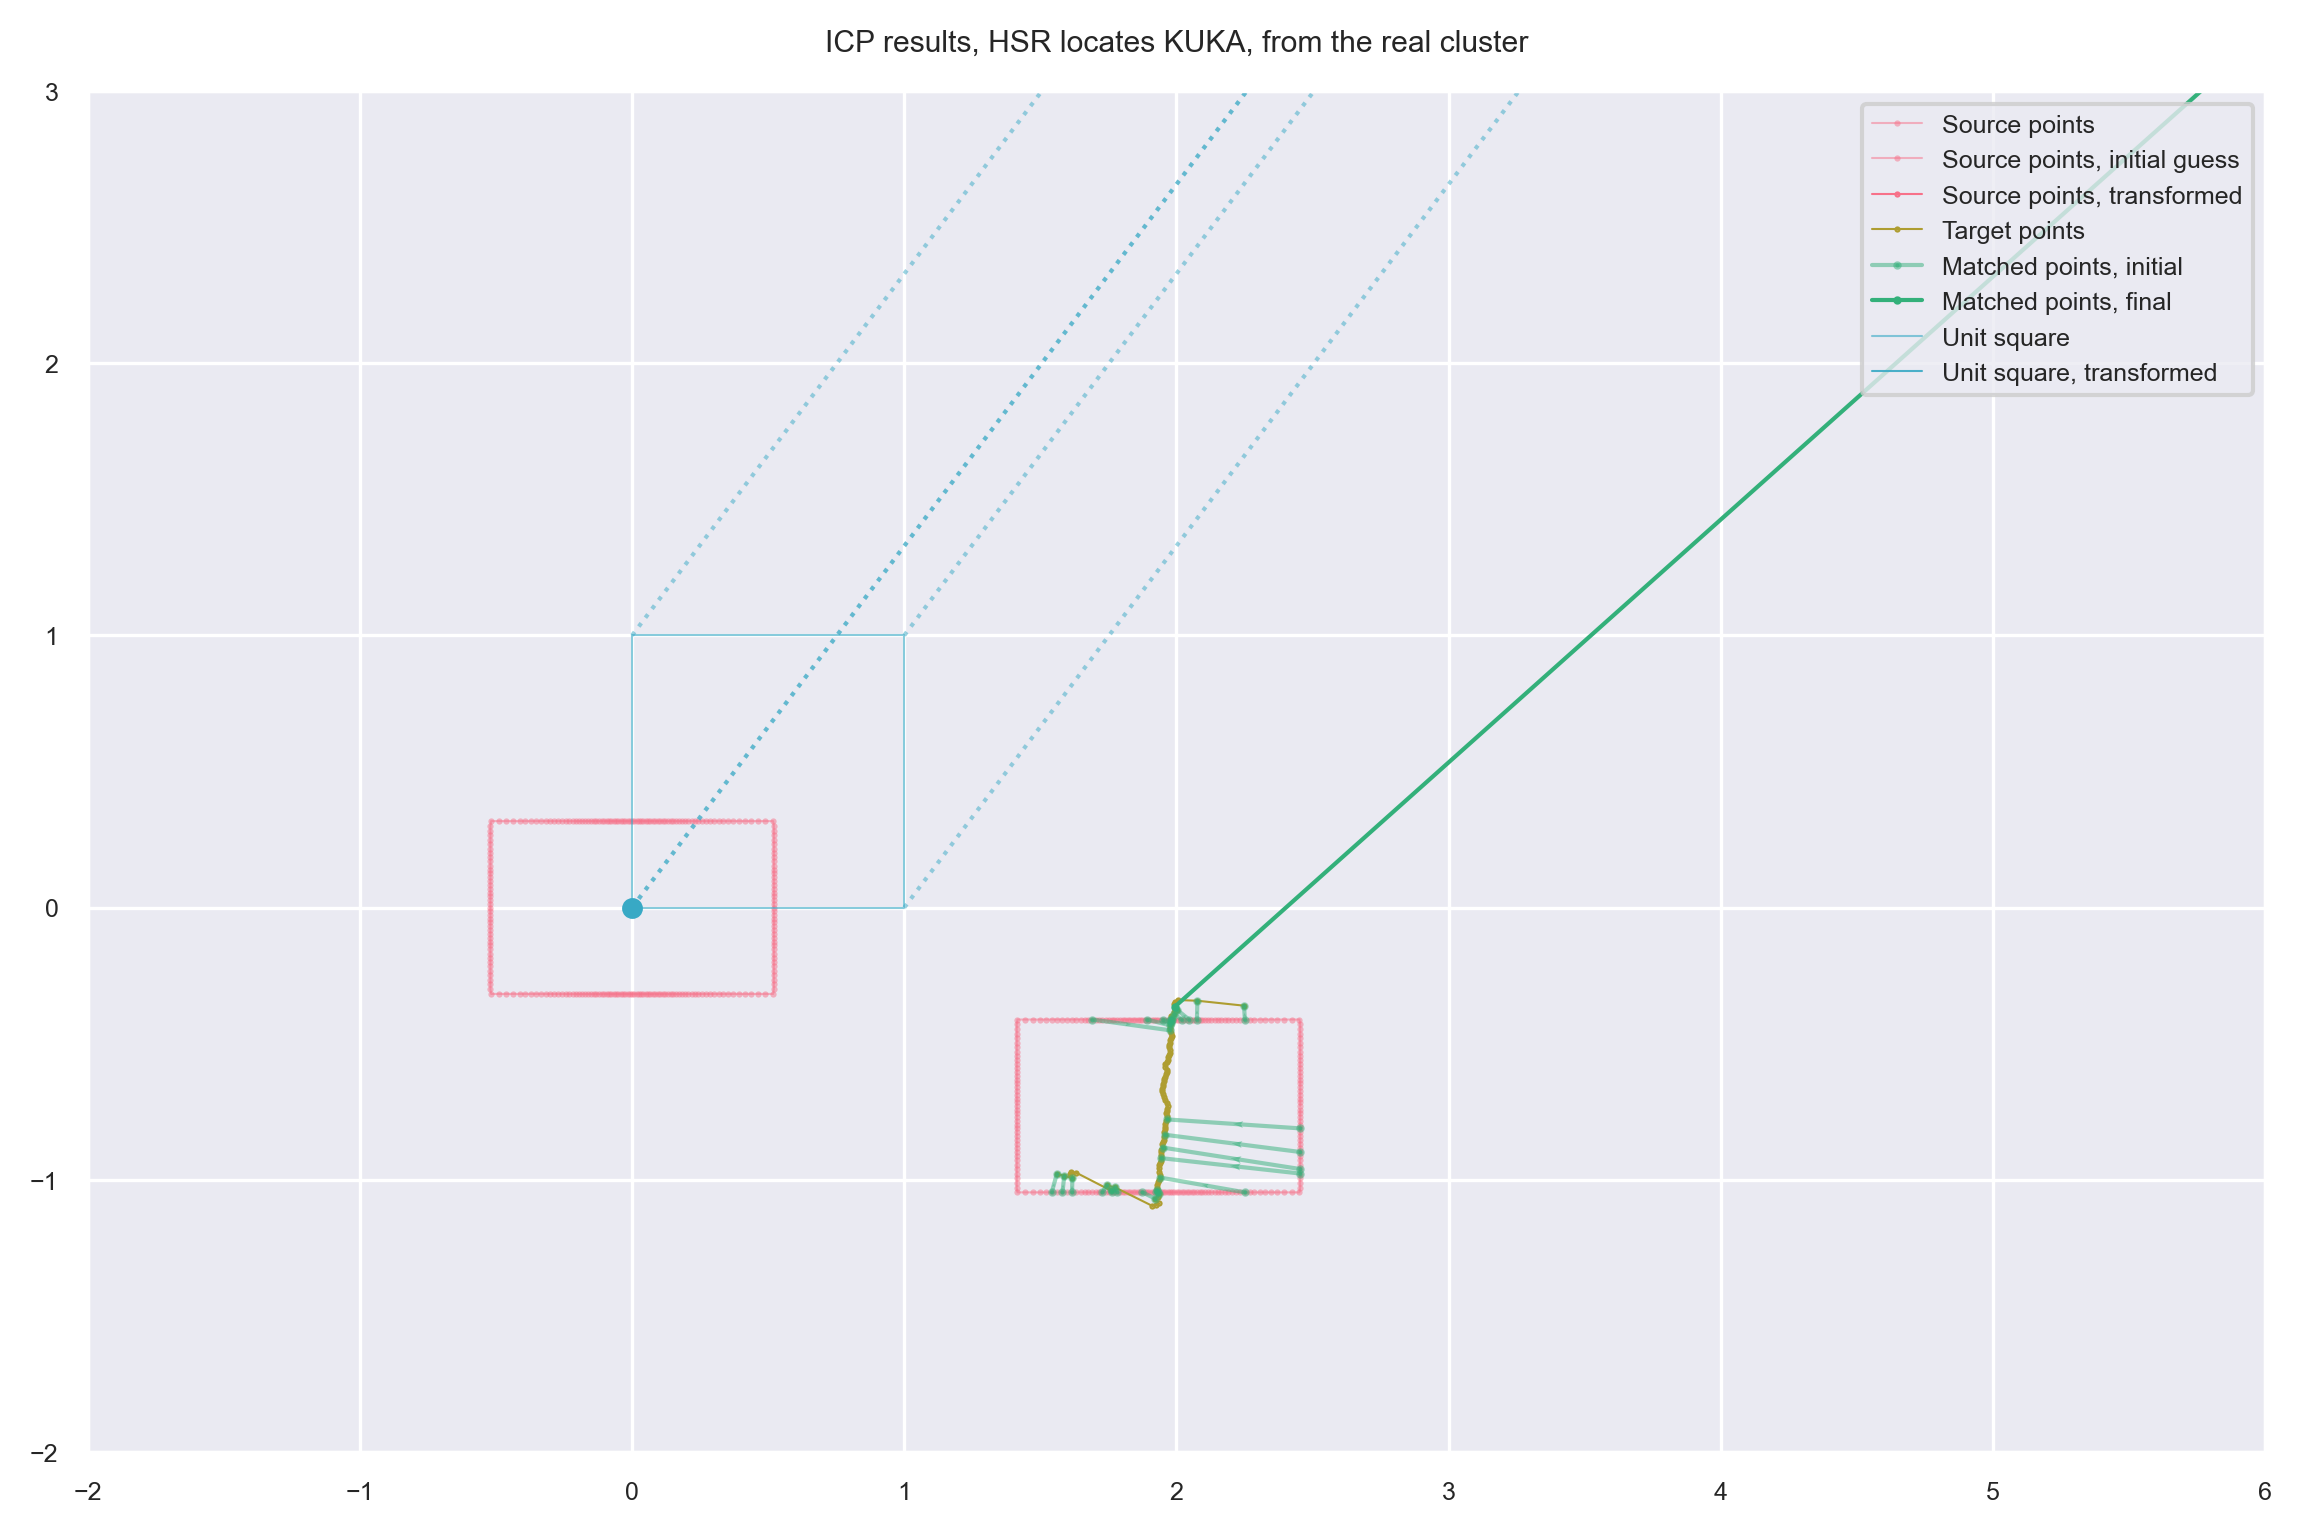

In [12]:
lbs = c(pts_hsr, approach='hierarchical', distance_threshold=1)   # A good clustering result by empirical inspection
d_clusters = {lb: pts_hsr[np.where(lbs == lb)] for lb in np.unique(lbs)}

cls = d_clusters[11]  # The cluster indicating real location of KUKA

visualize(
    pcr_kuka, cls,
    title='HSR locates KUKA, from the real cluster',
    init_tsf=tsl_n_angle2tsf(tsl=cls.mean(axis=0)),
    xlim=[-2, 6], ylim=[-2, 3],
    save=True
)


#### What if start with good translation guess?
Like above, or a perfect one?

Now, relatively, there's too much noise in the KUKA point cloud representation instead


ic| 'Initial guess': 'Initial guess'
    init_tsf: array([[ 1. , -0. ,  2.5],
                     [ 0. ,  1. , -0.5],
                     [ 0. ,  0. ,  1. ]])
ic| tsf_: array([[   0.98148928,   -0.19151707,  -10.31765279],
                 [  -0.19151707,   -0.98148928, -132.63987626],
                 [   0.        ,    0.        ,    1.        ]])
    tsl: array([ -10.31765279, -132.63987626])
    degrees(theta): 11.041332056341068


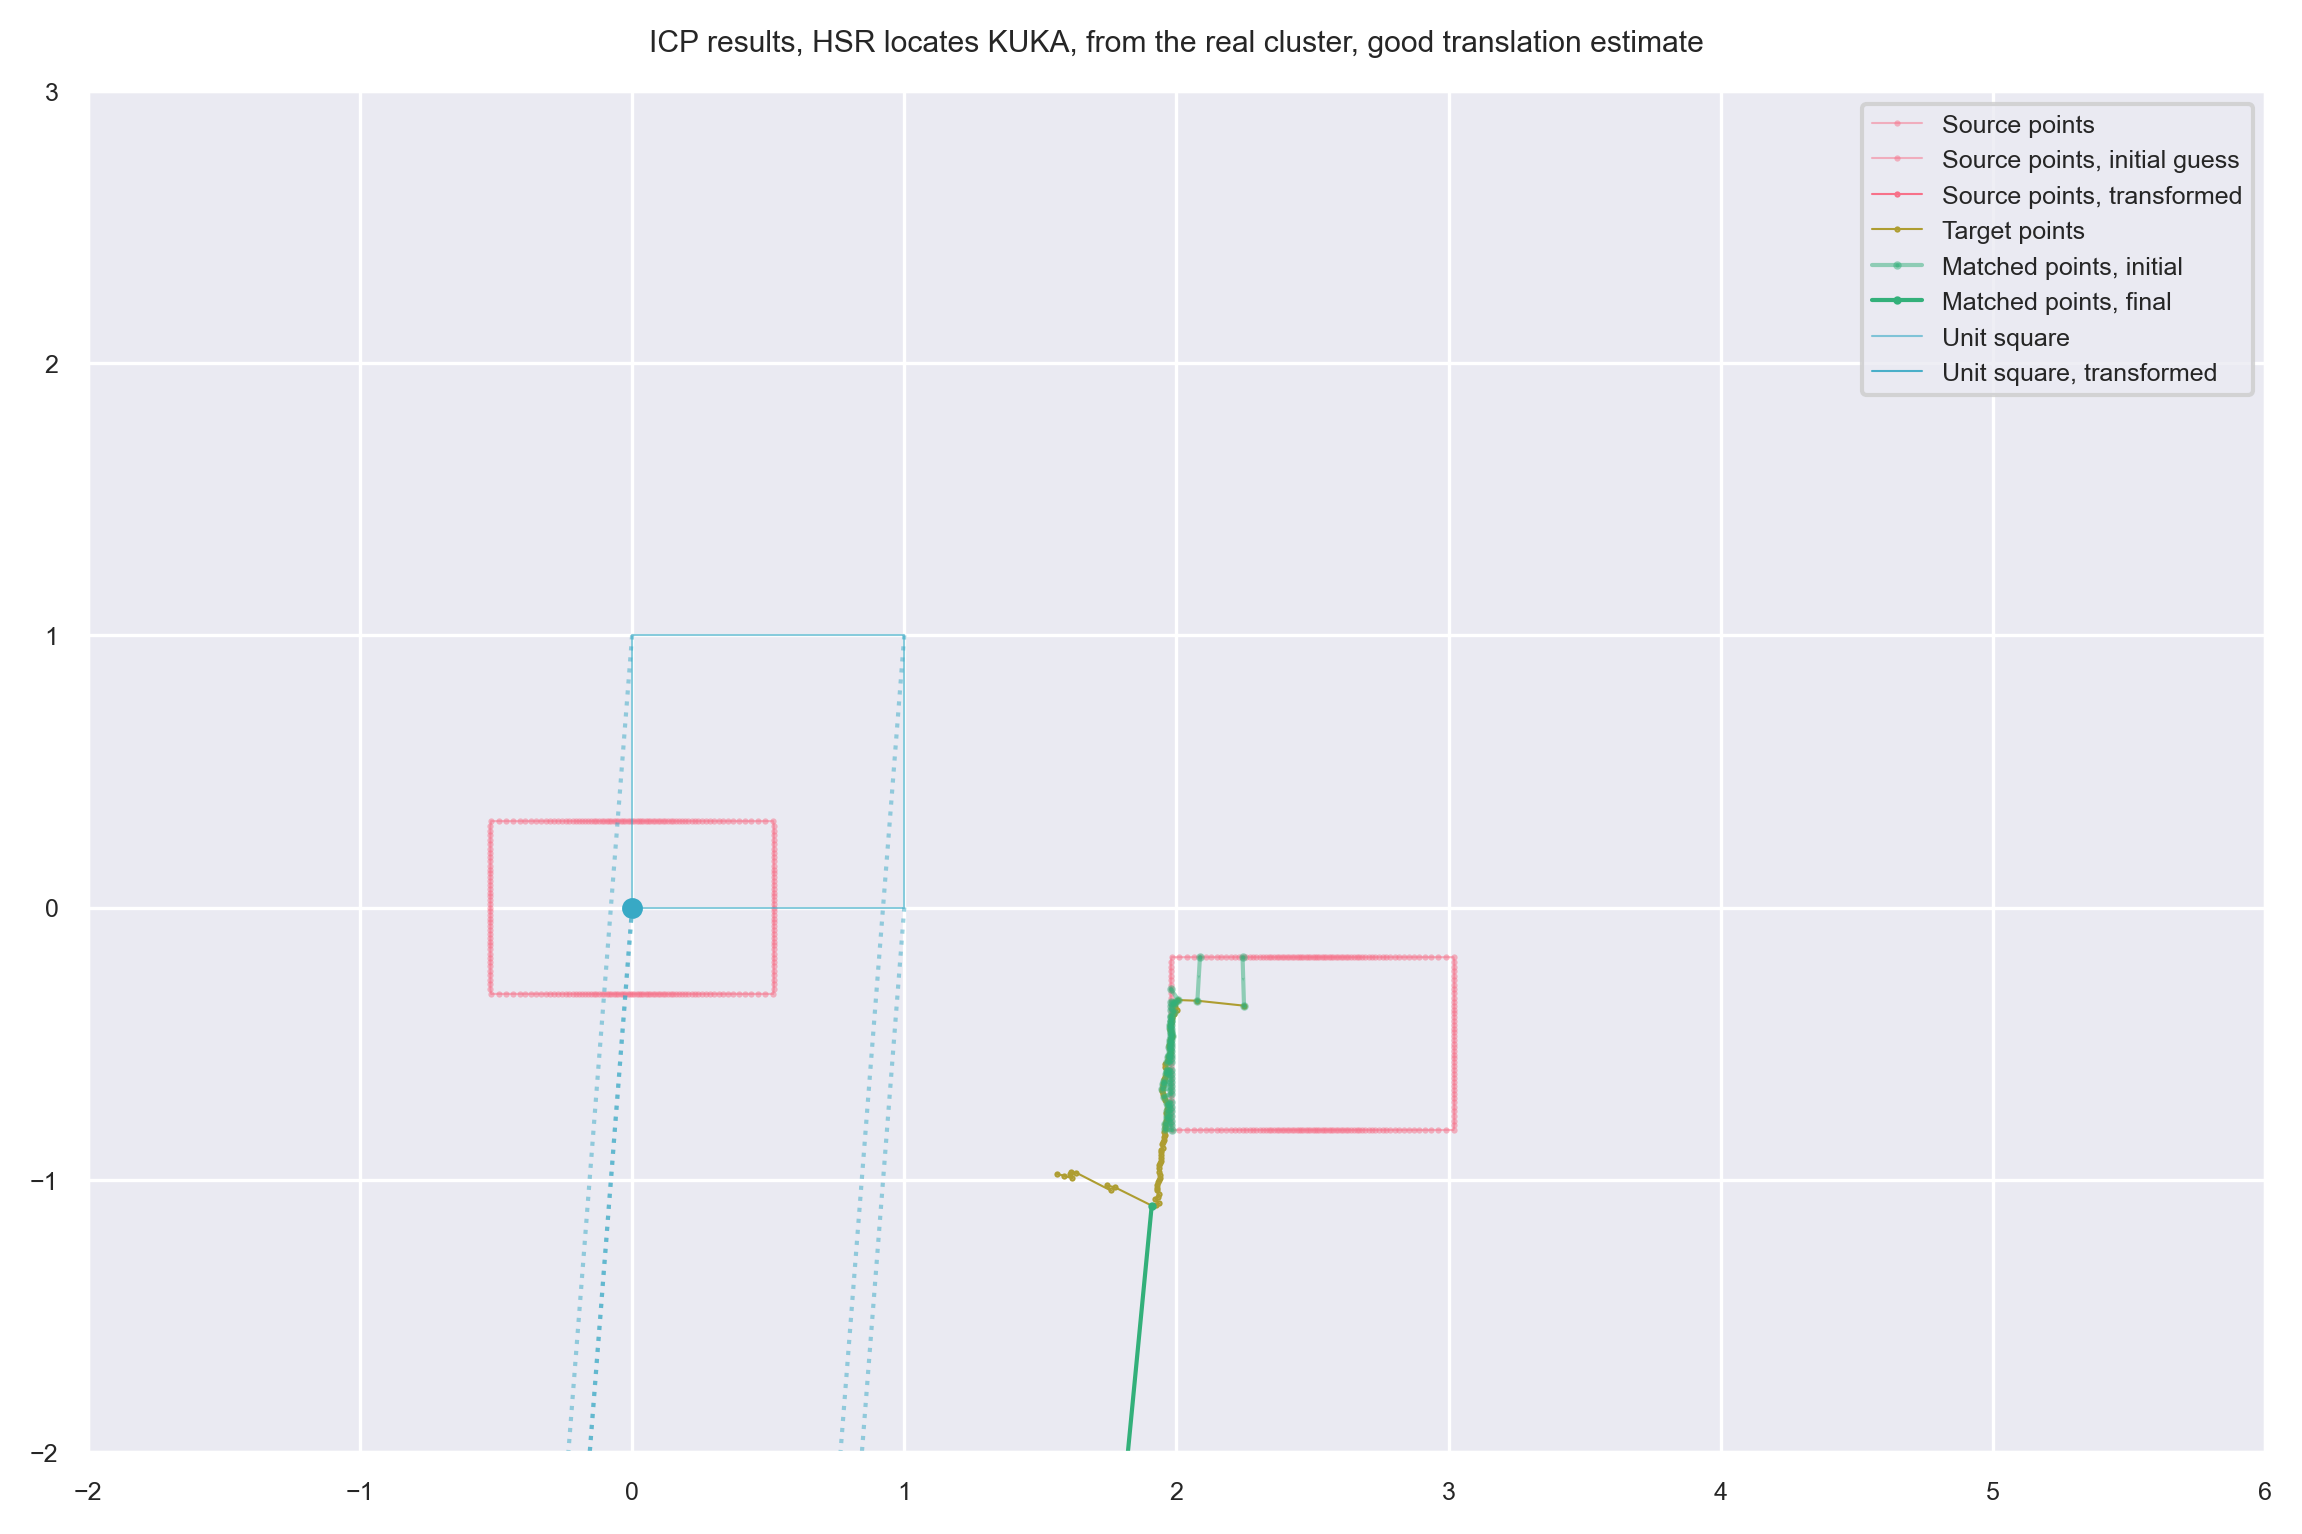

ic| 'Initial guess': 'Initial guess'
    init_tsf: array([[ 0.98877108,  0.14943813,  2.5       ],
                     [-0.14943813,  0.98877108, -0.75      ],
                     [ 0.        ,  0.        ,  1.        ]])
ic| tsf_: array([[ 7.39733707e-01, -6.72899727e-01,  5.99571681e+25],
                 [-6.72899727e-01, -7.39733707e-01,  1.55014933e+26],
                 [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
    tsl: array([5.99571681e+25, 1.55014933e+26])
    degrees(theta): 42.291263588835186


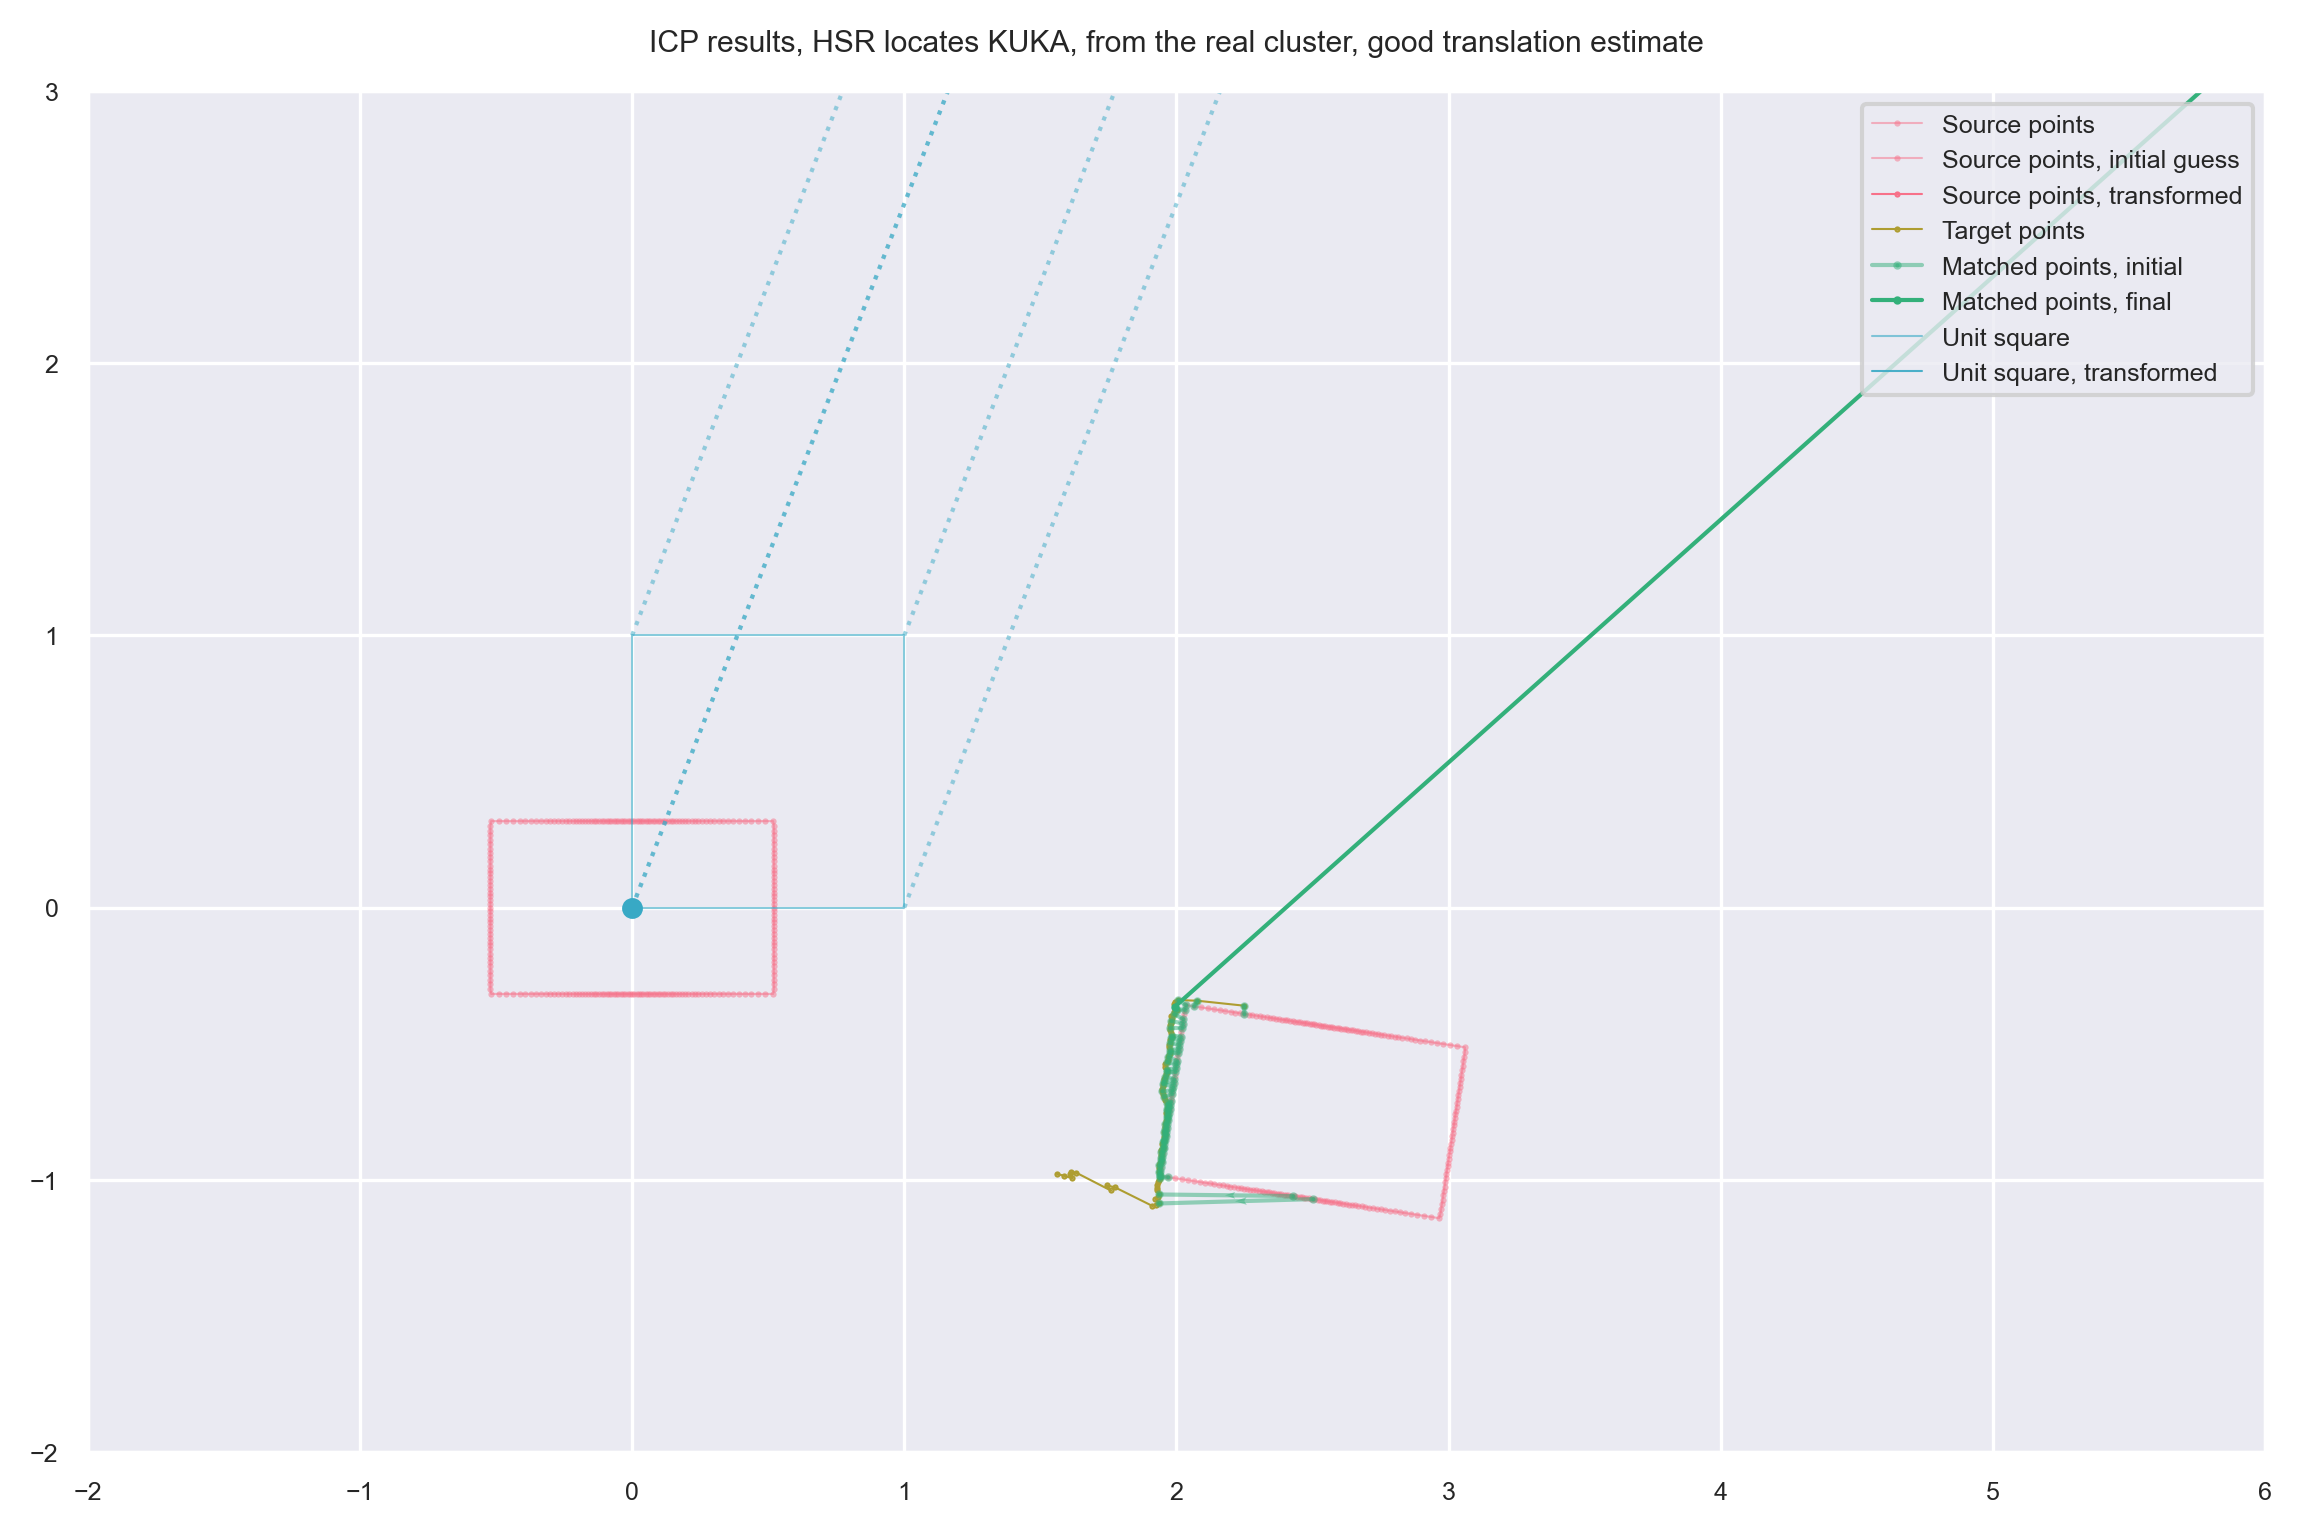

In [13]:
visualize(
    pcr_kuka, cls,
    title='HSR locates KUKA, from the real cluster, good translation estimate',
    init_tsf=tsl_n_angle2tsf(guesses['good_no_rotation']),
    xlim=[-2, 6], ylim=[-2, 3], mode='static',
    save=True
)
visualize(
    pcr_kuka, cls,
    title='HSR locates KUKA, from the real cluster, good translation estimate',
    init_tsf=tsl_n_angle2tsf(guesses['actual_pose']),
    xlim=[-2, 6], ylim=[-2, 3], mode='static',
    save=True
)


#### On top of translation guess, reverse?



ic| 'Initial guess': 'Initial guess'
    init_tsf: array([[ 1. , -0. , -2.5],
                     [ 0. ,  1. ,  0.5],
                     [ 0. ,  0. ,  1. ]])
ic| tsf_: array([[ 0.99738895, -0.07221688, -2.52595887],
                 [ 0.07221688,  0.99738895,  0.5194569 ],
                 [ 0.        ,  0.        ,  1.        ]])
    tsl: array([-2.52595887,  0.5194569 ])
    degrees(theta): 4.141327379332864


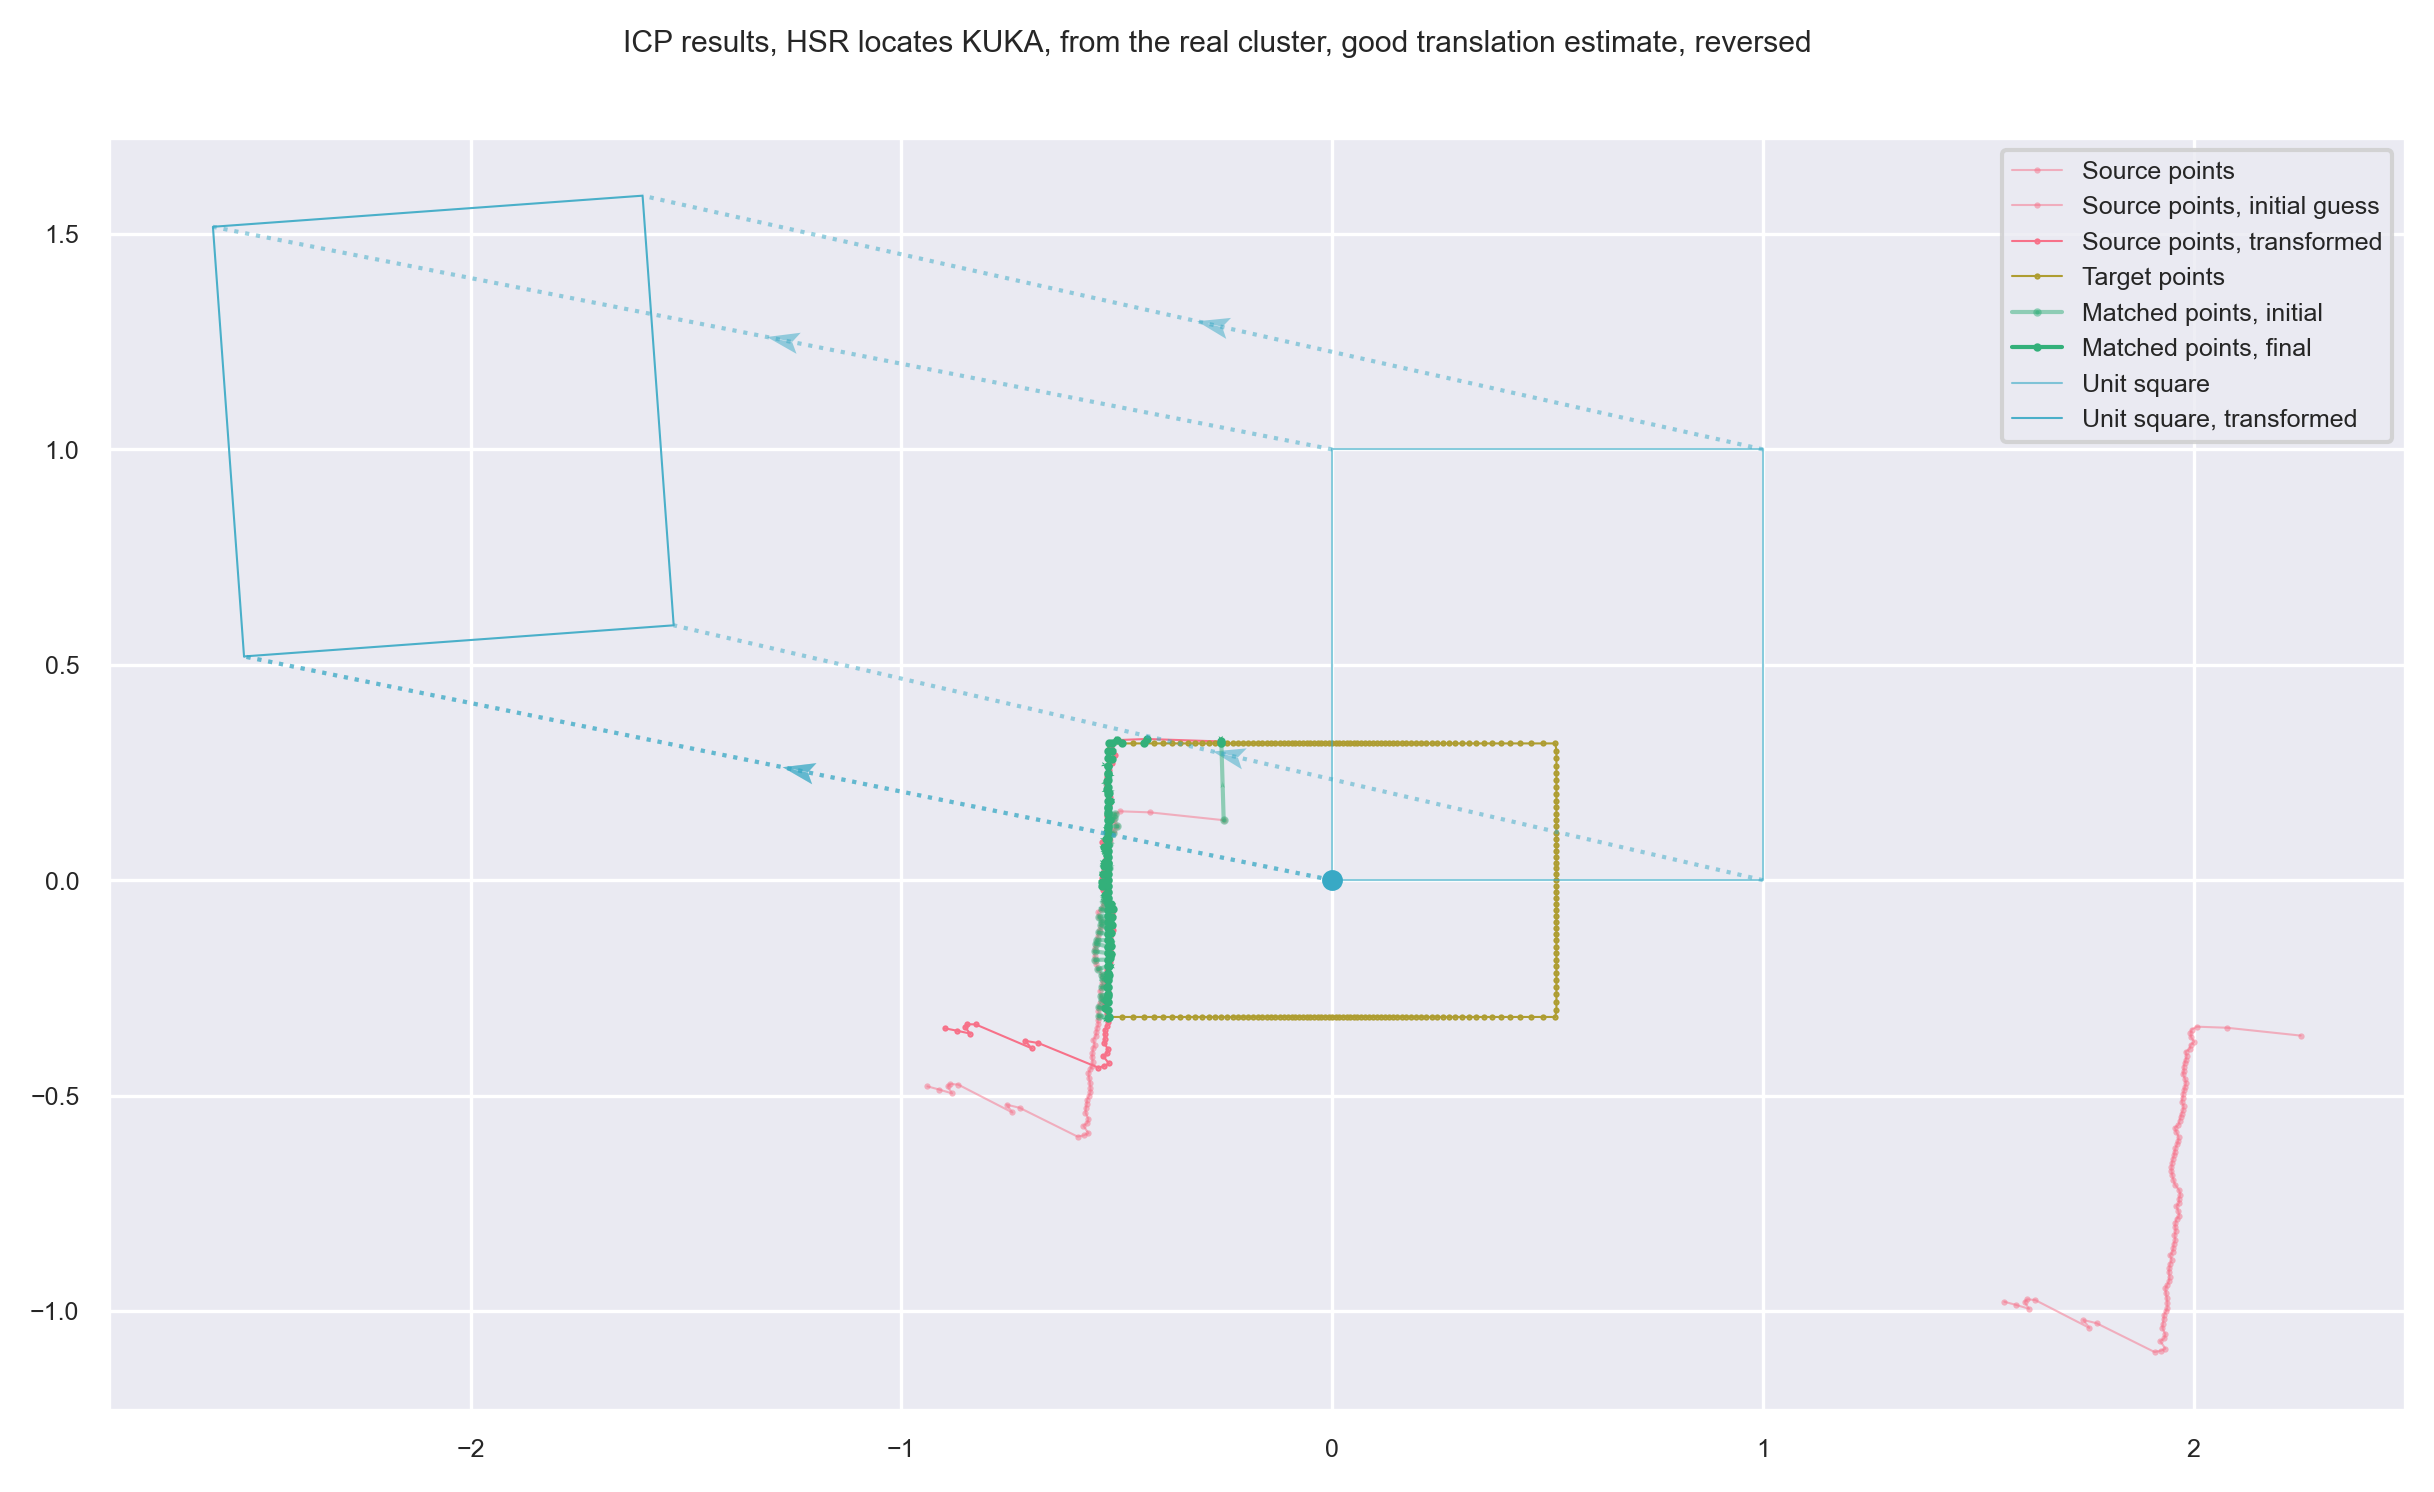

In [16]:
x, y = guesses['good_no_rotation']


visualize(
    cls, pcr_kuka,
    title='HSR locates KUKA, from the real cluster, good translation estimate, reversed',
    init_tsf=tsl_n_angle2tsf([-x, -y]),
    # xlim=[-2, 6], ylim=[-2, 3], mode='static',
    # save=True
)

